# A Complete Introduction and Walkthrough - First Try

이 노트북의 중반부부터는 Jerry Kwon님의 해석본을 참고하였습니다. 이 노트북을 해석해주신 Jerry Kwon님께 정말 감사드립니다.

https://www.kaggle.com/kwonyoung234/clone-of-will-koehrsen-s-translated-in-korean

## 1. Costa Rican Household Poverty Level Prediction
이 대회의 목적은 **개인과 가정의 특성을 모두 사용해 가정의 가난 정도를 예측**하는 머신러닝 모델을 만드는 것이다.     
이 노트북은 다음과 같은 순서로 진행된다:
- 문제를 살펴보기
- Exploratory Data Analysis(EDA)
- Feature Engineering
- 여러 개의 머신러닝 모델 설계
- 모델 선택
- 모델 최적화
- 모델의 출력 살펴보기
- conclusion

### 1.1. Problem and Data Explanation
이 대회에서는 `train.csv`와 `test.csv` 두 개의 파일이 제공된다. training set은 9557개의 로우와 143개의 컬럼을 가진 반면 testing set은 23856개의 로우와 142개의 컬럼을 가지고 있다. 각각의 로우는 하나의 개인을 나타내며 각 컬럼은 개인에게 고유한 피처이거나 개인의 가구에 대한 특징이다. training set은 추가로 하나의 컬럼은 갖고 있는데, `Target`이다. 이것은 대회의 Label값으로 가난의 정도를 1-4로 표현한다. 1이 가장 가난함을 뜻한다.

이것은 지도학습-다중클래스분류-머신러닝 문제이다:
* 지도학습(Supervised) : training data가 label과 함께 제공되는 것
* 다중 분류(Multi-class classification) : Label이 4개의 클래스로 나누어진 이산적인(discrete) 값

#### 1.1.1. Objective

이 대회의 목적은 다시 말하다싶이 가정의 빈곤 정도를 예측하는 것이다. 우리는 개인에 대한 데이터를 제공받는데, 각 개인에 대한 피처는 물론 그들의 가정에 대한 정보도 포함되어 있다. 제대로된 데이터셋을 만들기 위해서는, 각 가정에 대해 개별 데이터를 집계를 해야한다. 더구나 test set에서 각 개인에 대한 예측을 해야하지만 "점수에 가장(household)만 점수에 사용된다"는 말로 보아 우리는 가정/가계를 기준으로 가난 정도를 예측해야함을 뜻한다.

**Important Note: training data에서 가정의 모든 일원들은 같은 Label값을 가져야 하지만, 동일한 가구의 개인이 다른 라벨을 가지고 있는 오류(error)가 있을 수 있다. 이 경우, `parentescol == 1.0`인 로우로 식별할 수 있는 각 가장의 라벨을 사용하라고 한다. 자세한 것은 노트북에서 확인!**

`Target` 값은 가난의 정도를 의미한다:
* 1 = 극단적 빈곤
* 2 = 적당히 빈곤
* 3 = 취약 가구
* 4 = 취약하지 않은 가구

143개의 컬럼에 대한 설명은 [대회의 다큐먼트](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data)에서 확인할 수 있다. 몇몇 피처에 대해 설명하면 다음과 같다:
* `Id` : 개인을 구분하기 위한 식별자. 모델 학습 시 사용하지는 않을 예정
* `idhogar` : 각 가정을 구분하기 위한 식별자. 이 변수는 피처는 아니지만 같은 식별자를 가진 개인끼리 묶어 하나의 가정으로 그룹핑할 때 사용할 예정.
* `parentesco1` : 해당 사람이 가정의 가장인지
* `Target` : 라벨값. 같은 가정이면 모든 구성원은 같은 값을 가진다.

우리가 모델을 만들 때, 각 가정을 나타내는 라벨, 가장의 빈곤 정도를 가지고 가정을 바탕으로 학습을 시킬 것이다. 원본 데이터는 가정과 개인 둘다에 대한 내용이 섞여있으며, 개인 데이터에 대해서 우리는 각 가정마다 집계할 것이다. 몇몇 개인데이터는 가장이 없는 가정에 속해있는 경우가 있는데 이런 경우 우리는 이 데이터를 학습 시 사용할 수 없다. 

#### 1.1.2. Metric

궁극적으로 우리는 가정의 빈곤 정도를 예측하는 머신러닝 모델을 만드는 것이다. 우리의 예측은 Macro F1 Score로 평가될 것이다. precision과 call의 조화평균인 F1 Score는 binary classification에서 익숙할 것이다.

$$F_1= \frac{2}{\frac{1}{recall}+\frac{1}{precision}}=2⋅\frac{precision⋅recall}{precision+recall}$$

다중 분류 문제에서는 각 클래스별 F1 score의 평균을 내야 한다. macro F1 score는 라벨 분균형(label imbalance) 문제를 고려하지 않고 각 클래스별 F1 score를 평균을 낸 것이다.

$$Macro F1=\frac{F1 Class 1+F1 Class 2+F1 Class 3+F1 Class 4}{4}$$

즉, macro("가중치" 점수를 사용할 때(?))를 사용할 때는 각 라벨의 발생 횟수는 계산에 반영되지 않는다. 더 자세한 내용은 [Scikit-Learn Documention for F1 Score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) 나 [Stack Exchange question and answers](https://datascience.stackexchange.com/q/15989/42908)를 참고! 평가 시 다음의 코드를 사용한다.

```python
from sklearn.metrics import f1_score
f1_score(y_true, y_predicted, average='macro')
```

이 문제에서 라벨이 분균형하므로 평가 지표로 macro averaging을 사용하는 건 조금 이상해 보인다. 하지만 이건 대회 조직한 사람들이 결정한 문제이고 우리가 바꿀 수 있는 것은 없다. 하지만 실제로는 라벨 분균형 문제를 고려하고 그에 따른 적절한 평가 지표를 골라야 한다.

### 1.2. Roadmap
다시 한 번 말하지만 우리의 목적은 가정의 빈곤 정도를 예측하는 머신러닝 모델을 만드는 것이다. 하지만, 모델링을 하기 전에 문제와 데이터를 이해하는 것은 중요하다. 또한 우리는 최고의 모델을 뽑기 전에 수많은 모델을 평가해야하고 모델을 만든 후에도 예측값을 살펴(investigate)보아야 한다. 그러므로 우리의 로드맵은 다음과 같다:
1. 문제를 이해하기 (이미 했음)
2. EDA
3. 특성 공학
4. 몇몇 베이스라인 모델 비교하기
5. 더 복잡한 머신러닝 모델 시도
6. 선택된 모델 최적화
7. 문제의 문맥에서 예측값을 조사
8. 결론 도출 및 다음 단계 계획

위의 제시된 단계들은 하나씩 차근차근 밟아가겠지만 다시 전 단계로 돌아가서 우리의 결정들을 재검토해볼 수 있다. 일반적으로 데이터 과학은 과거의 결정을 끊임없이 평가하고 개선해 나가는 비선형적인 연습(practice)(?)이다. 특히 특성 공학, 모델링, 최적화는 우리가 처음에는 제대로 했는지 모르기 때문에 자주 반복하는 단계들이다.

## 2. Getting Started
문제를 어느정도 이해했으니 이제 EDA와 특성 공학 단계로 넘어가보자. EDA에서는 우리는 특성공학과 모델링에 사용할  흥미로운 이상치, 경향, 상관관계, 패턴들을 살펴볼 것이다. 우리는 데이터를 정량적으로(=통계적으로) 그리고 figure, plot으로 시각적으로 살펴볼 것이다.

데이터와 잠재적으로 유용한 관계를 잘 이해했다면, 우리는 특성공학을 하고 베이스라인 모델을 설계할 수 있다. 이것이 우리를 리더보드의 짱짱으로 만들 수는 없지만 기초를 튼튼하게 해줄 것이다.

### 2.1. Imports

In [527]:
# 데이터 조작
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 플라팅(plotting)을 위한 기본 세팅
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size']= 18
plt.rcParams['patch.edgecolor'] = 'k'
# sns.distributions._has_statsmodels = False

### 2.2. Read in Data and Look at Summary Information

In [528]:
# 데이터프레임 디스플레이시 최대 컬럼 수 지정
pd.options.display.max_columns = 150

# 데이터 로드
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


한 눈에 봐도 컬럼들끼리 순서가 없는 것을 볼 수 있다. `df.info()`로 간략한 개요를 살표보자.

In [529]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


이를 보아 130개의 정수로된 컬럼, 8개의 실수형(numeric) 컬럼, 5개의 문자열 컬럼이 있다는 것을 알 수 있다. 정수형 컬럼은 아마도 불리언 변수(0 or 1) 나 이산적인 순서 값으로 서수형 변수를 표현하는 것이다. 문자열 컬럼은 모델에 직접적으로 쓰일 수 없기 때문에 문제가 될 수 있다.

학습 데이터와 비교했을 때 테스트 데이터가 몇 개의 로우(개개인)를 가지고 있는지 살펴보자. `Target`이 존재하지 않기 때문에 1개가 부족할 것이다.

In [530]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


### 2.3. Integer Columns
정수형 변수의 고유값(unique value)의 분포를 살펴보자. 각 컬럼에 대해 고유값의 개수를 새어 barplot으로 그 결과를 보여줄 것이다.

Text(0.5, 1.0, 'count of unique values in integer columns')

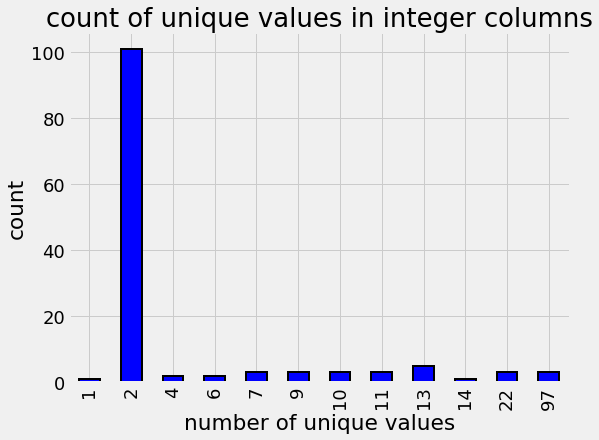

In [531]:
# 정수형 변수의 고유값 분포 - barplot
# 1. 학습 데이터에서 정수형 컬럼 추출
# 2. 각 컬럼별 고유값의 개수 계산
# 3. 각 개수별 컬럼 수 카운팅
# 4. 개수를 기준으로 정렬
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(
    color='blue', figsize=(8, 6), edgecolor='k', linewidth=2)
plt.xlabel('number of unique values')
plt.ylabel('count')
plt.title('count of unique values in integer columns')

고유값이 2개인 컬럼은 불리언(0 or 1) 변수를 나타낸다. 대부분의 경우 이 불리언 정보는 이미 가구(가정)의 수준에 있다(?: 가정에 대한 데이터라는 의미인듯) 예를 들어, `refig` 컬럼은 가정에 냉장고가 있는지 여부이다. 가구 수준에 있는 불리언 컬럼으로부터 피처를 만들 때, 우리는 굳이 집계를 할 필요가 없다. 하지만, 개별 수준에 있는 불리언 컬럼은 집계를 할 필요가 있다.

### 2.4. Float Columns
다른 컬럼 타입으로 실수형이 있고 이는 연속적인 변수를 나타낸다. 우리는 모든 실수형 컬럼들의 분포를 보기 위해 간단한 분포 그래프를 그려볼 수 있다. 우리는 `OrderedDict`를 사용하여 빈곤 정도를 특정 색으로 매핑을 할 것이다. 왜냐하면 파이썬 딕셔너리와는 다르게 key와 value 쌍의 순서가 유지되기 떄문이다.

다음의 그래프는 `Target`의 값에 따라 색칠된 실수형 변수들의 분포를 보여준다. 이 그래프를 가지고 우리는 빈곤 정도에 따른 분포의 차이를 살펴볼 수 있다.

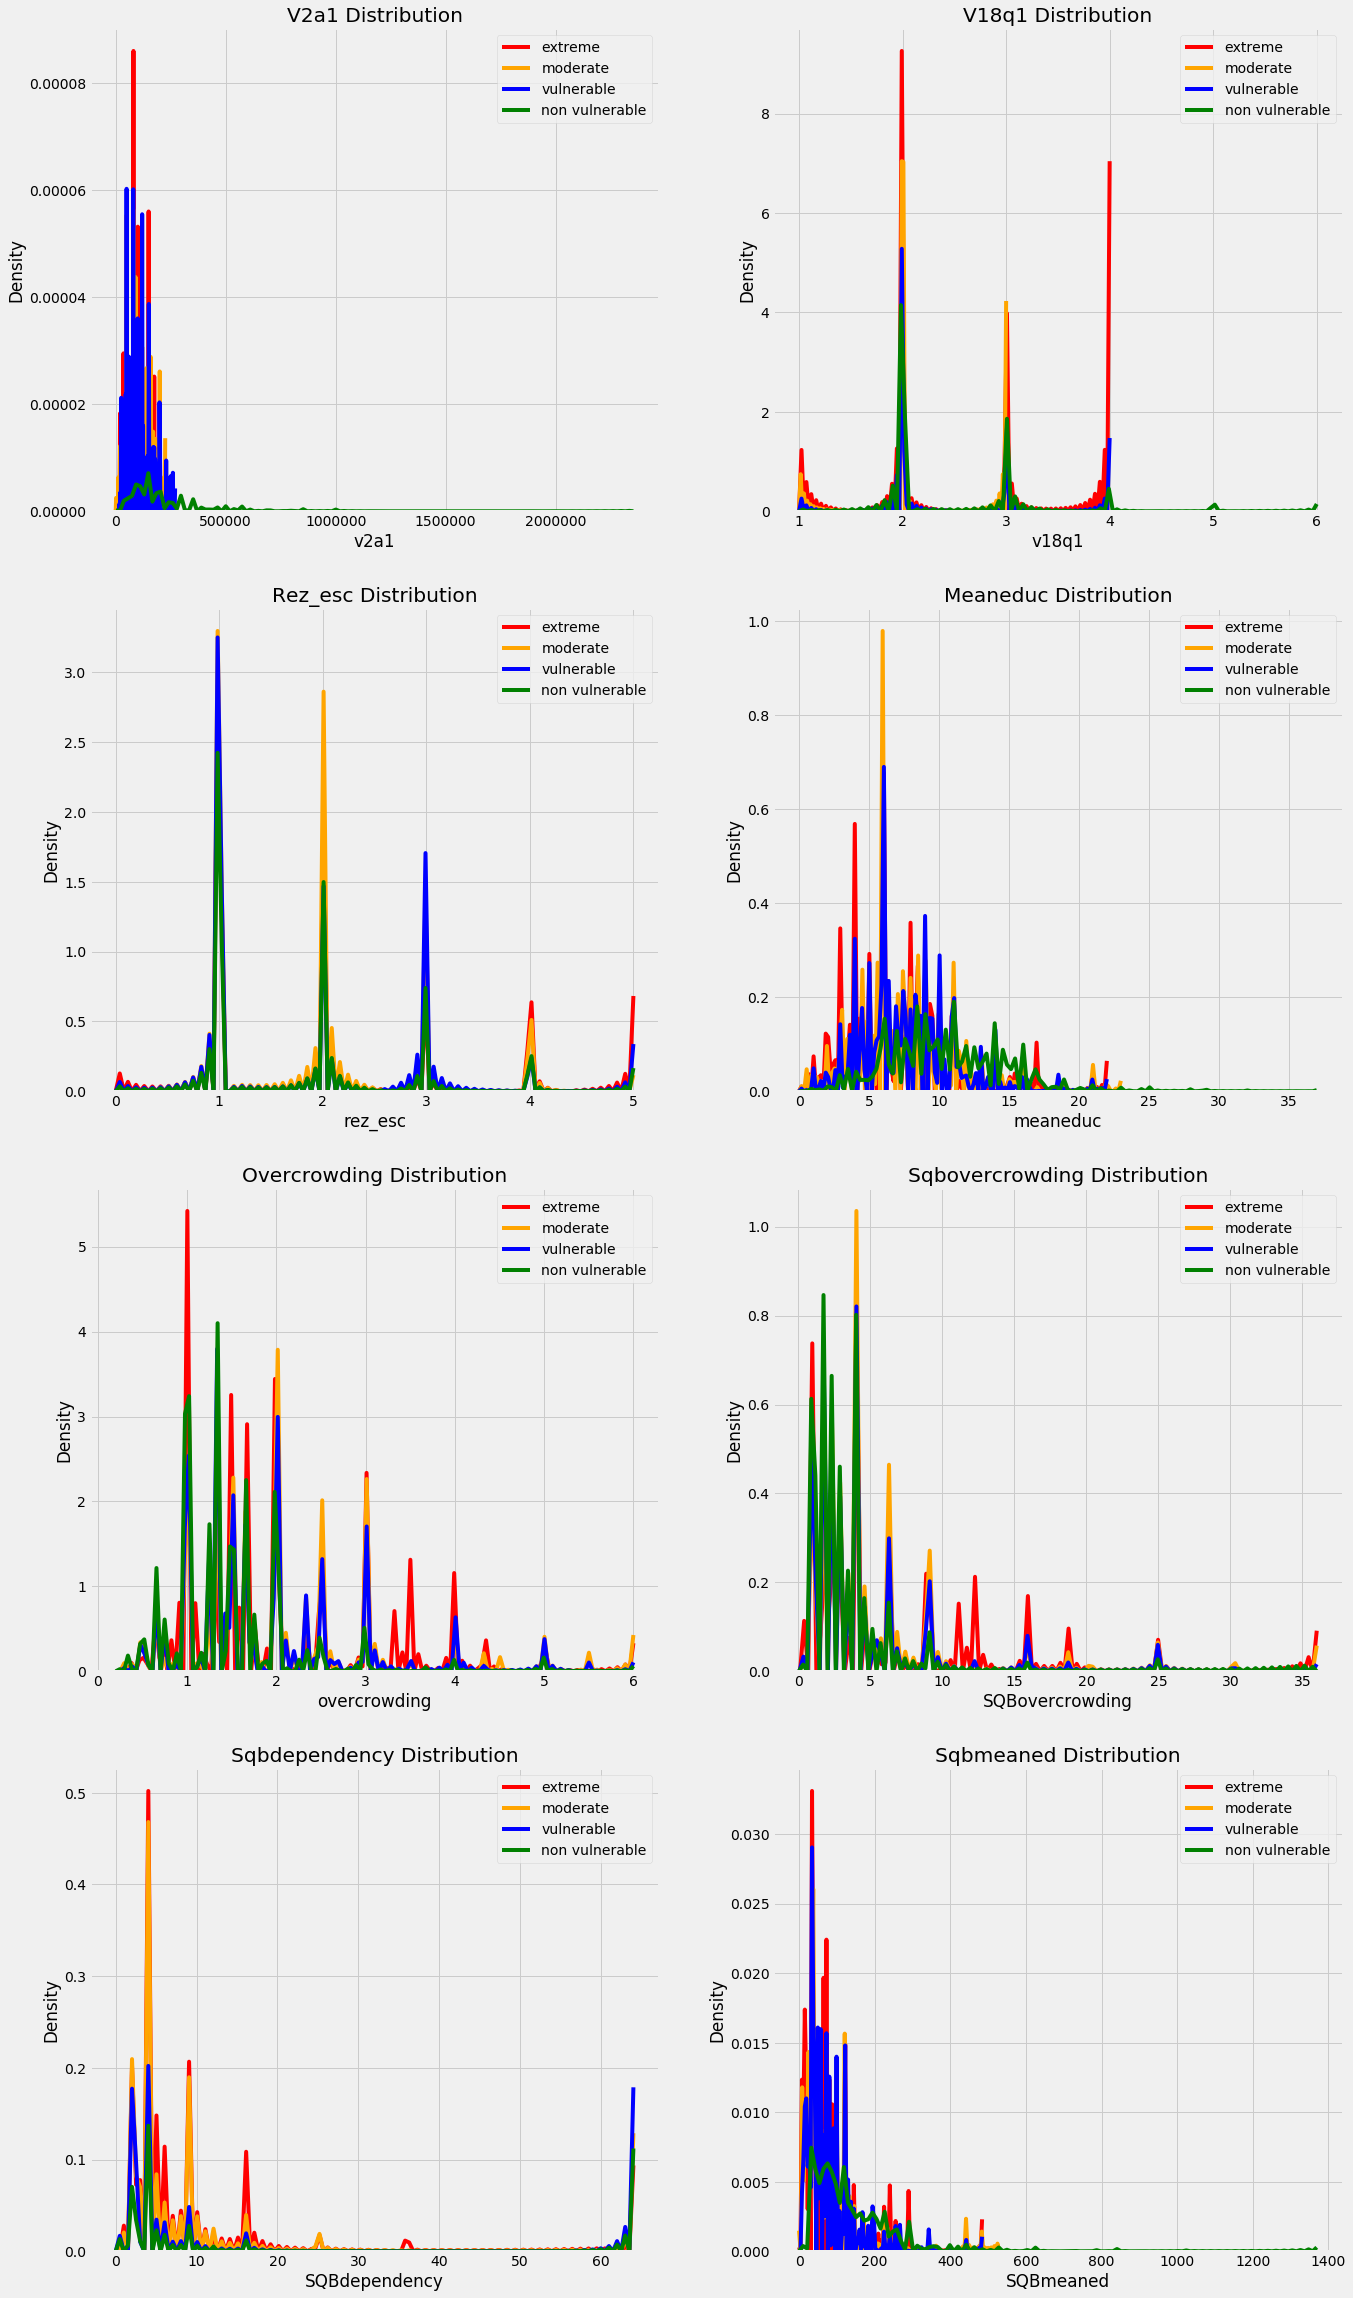

In [532]:
from collections import OrderedDict

plt.figure(figsize=(20, 16))
plt.style.use('fivethirtyeight')

# 빈곤정도 색깔 매핑
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
# 정수와 빈곤정도 매핑
poverty_mapping = OrderedDict(
    {1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4, 2, i+1)

    # 각 빈곤 정도별 분포 - kdeplot
    for poverty_level, color in colors.items():
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax=ax, color=color, label=poverty_mapping[poverty_level], bw=0)
    
    plt.title(f'{col.capitalize()} Distribution')
    plt.xlabel(f'{col}')
    plt.ylabel('Density')
    
# subplot의 위의 간격 조절
plt.subplots_adjust(top=2)

seaborn 에러로 인해 아래에 Notebook의 plot을 첨부한다. 
> https://github.com/mwaskom/seaborn/issues/1990

![real-result](../img/float-dist-plot.png)

나중에 피처간의 관계를 측정하기 위해 우리는 변수와 타켓 변수의 상관관계를 계산할 것이다. 하지만 이 plot들은 이미 어떤 변수가 모델 학습과 가장 관련있는 변수인지 알려주고 있다. 예를 들어, 가정 내 성인의 평균 교육을 나타내는 `meaneduc`은 빈곤 정도와 관련이 높은 것으로 보인다. 즉, 평균 교육 수준이 높을수록 타켓값은 더 높은 경향을 보여준다. 즉, 덜 가난하다는 것을 보여준다. 교육의 중요성에 대한 주제는 이 Notebook에서 다시 설명할 예정!

### 2.5. Object Columns

In [533]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


`Id`와 `idhogar`는 식별하기 위함이므로 타당하다. 하지만, 다른 컬럼들은 학습을 하기 전에 다루어야할 문자열과 숫자의 혼합인 것 같다. 이 컬럼들에 대한 설명은 다음과 같다:
* `dependency` : 종속율. (19세 이하 가구원 수 또는 64세 이상의 가구원 수)/(19세~64세인 가구원의 수)
* `edjefe` : 에스코라리(교육 년수), 가장, 성별의 상호작용(?)을 바탕으로 남성 가장의 교육 년수 1(yes) or 0(no)
* `edjefa` : 에스코라리(교육 년수), 가장, 성별 상호작용(?)을 바탕으로 여성 가장의 교육 년수 1(yes) or 0(no)

이 3개의 변수의 경우 `yes==1`과 `no==0`으로 매핑을 이용해 변수를 수정하고 실수형으로 바꿔줄 수 있다.

In [534]:
mapping = {'yes':1, 'no':0}

# 학습 데이터와 테스트 데이터 모두에게 적용
for df in [train, test]:
    # 적절한 매핑으로 값 채우기
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)

train[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


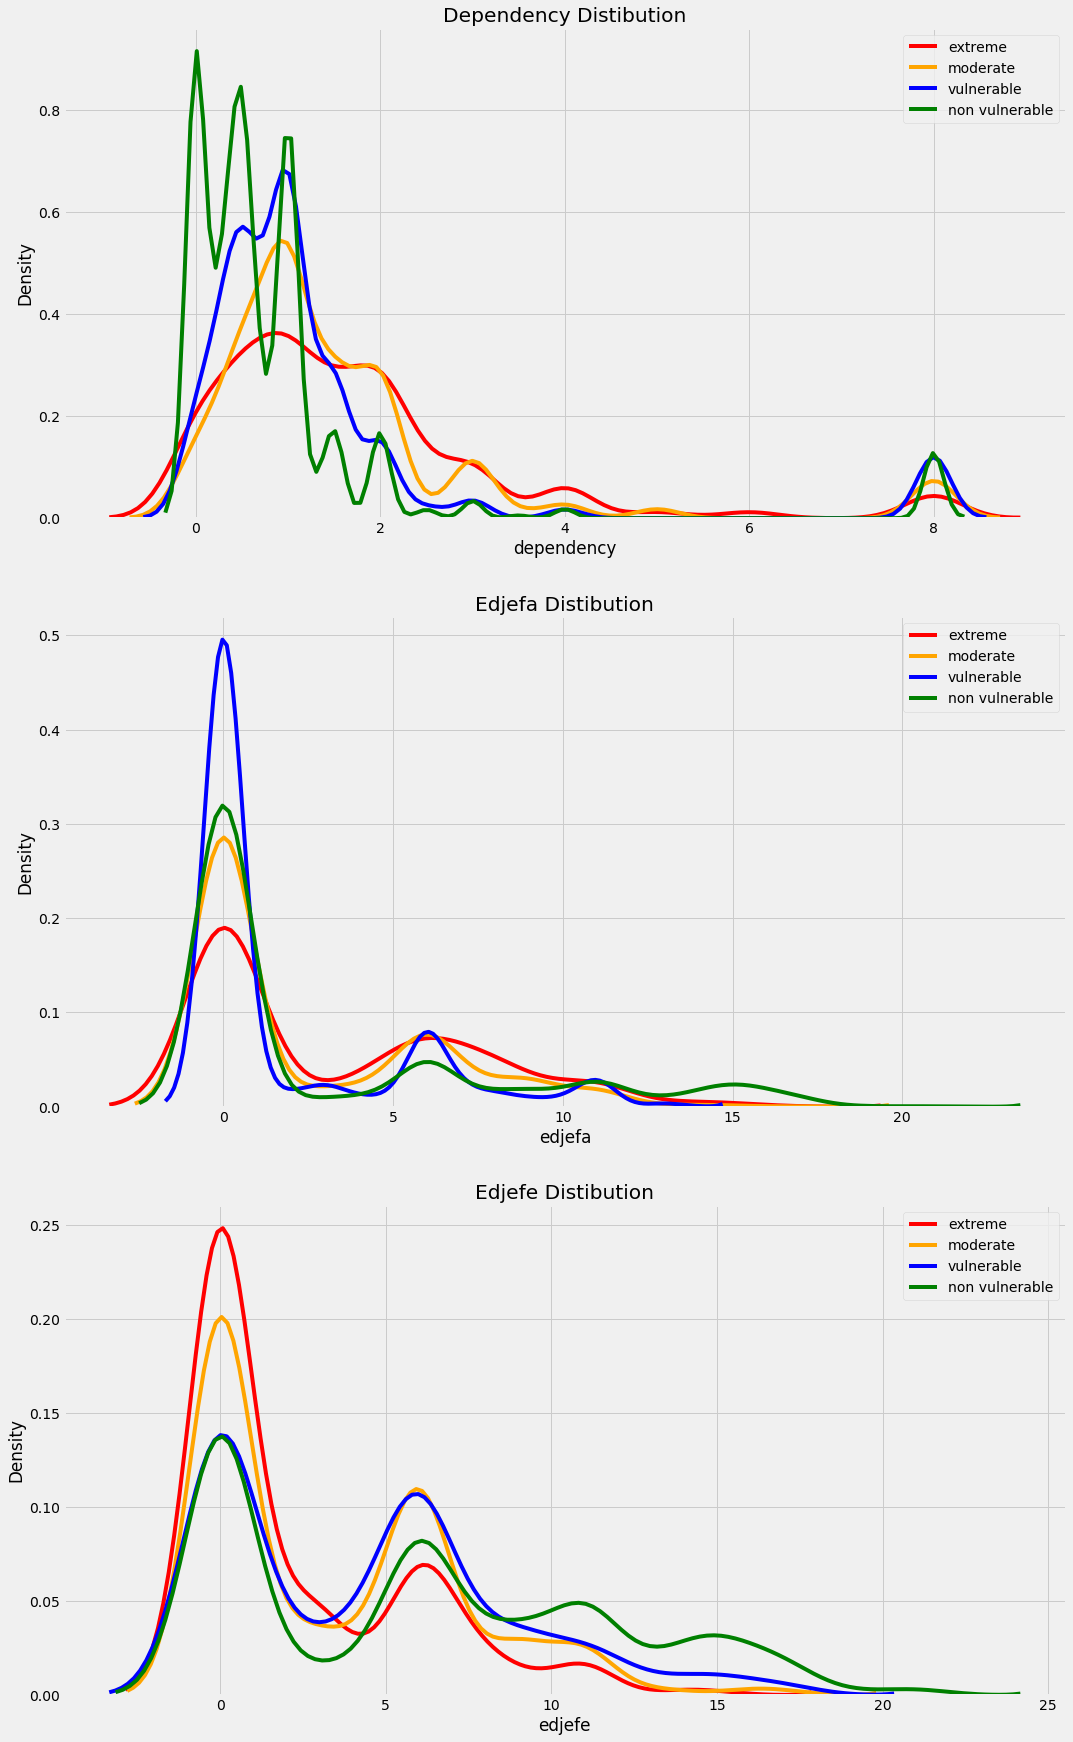

In [535]:
plt.figure(figsize=(16, 12))

for i, col in enumerate(['dependency', 'edjefa', 'edjefe']):
    ax = plt.subplot(3, 1, i+1)

    # 각 빈곤정도 별 분포 - kdeplot
    for poverty_level, color in colors.items():
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(
        ), ax=ax, color=color, label=poverty_mapping[poverty_level])

    plt.title(f'{col.capitalize()} Distibution')
    plt.xlabel(f'{col}')
    plt.ylabel(f'Density')

plt.subplots_adjust(top=2)

이 변수들은 숫자로 잘 표현되고 이제는 머신러닝 모델에 넣을 수 있다.

위와 같은 작업을 조금 더 쉽게 하기 위해, 학습 데이터와 테스트 데이터프레임을 함칠 것이다. 이는 우리가 특성공학을 할 때 중요하다. 왜냐하면 같은 작업을 2개의 데이터프레임에 모두 적용해 같은 피처들을 사용하고자하기 때문이다. 나중에 Target을 기준으로 세트를 분리할 수 있다.

In [536]:
# 테스트 데이터에 Target 컬럼을 NaN값으로 추가
test['Target'] = np.nan
# 학습 데이터와 테스트 데이터 결합
data = train.append(test, ignore_index=True)
data.tail()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
33408,ID_a065a7cad,NaN,1,2,1,1,1,0,NaN,0,2,2,1,3,4,1,5,6,6,6,3,0.0,6,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,3aa78c56b,2,4,0,6,0.5,5.0,0.0,5.75,0,1,0,0,0,0,0,0,0,1,6.0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,10,9,100,36,25,4,36.0,0.25,33.0625,100,NaN
33409,ID_1a7c6953b,NaN,0,3,0,1,1,0,NaN,0,1,1,0,3,3,0,4,4,4,4,6,NaN,4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,d237404b6,2,2,0,4,1.0,6.0,0.0,6.00,0,0,1,0,0,0,0,0,0,2,2.0,1,0,0,0,0,0,0,1,2,0,0,0,0,0,1,0,1,54,36,2916,16,36,4,4.0,1.00,36.0000,2916,NaN
33410,ID_07dbb4be2,NaN,0,3,0,1,1,0,NaN,0,1,1,0,3,3,0,4,4,4,4,4,1.0,4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,d237404b6,2,2,0,4,1.0,6.0,0.0,6.00,0,1,0,0,0,0,0,0,0,2,2.0,1,0,0,0,0,0,0,1,2,0,0,0,0,0,1,0,1,12,16,144,16,36,4,4.0,1.00,36.0000,144,NaN
33411,ID_34d2ed046,NaN,0,3,0,1,1,0,NaN,0,1,1,0,3,3,0,4,4,4,4,5,0.0,4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,d237404b6,2,2,0,4,1.0,6.0,0.0,6.00,0,1,0,0,0,0,0,0,0,2,2.0,1,0,0,0,0,0,0,1,2,0,0,0,0,0,1,0,1,12,25,144,16,36,4,4.0,1.00,36.0000,144,NaN
33412,ID_34754556f,NaN,0,3,0,1,1,0,NaN,0,1,1,0,3,3,0,4,4,4,4,6,NaN,4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,d237404b6,2,2,0,4,1.0,6.0,0.0,6.00,0,0,1,0,0,0,0,0,0,2,2.0,1,0,0,0,0,0,0,1,2,0,0,0,0,0,1,0,1,51,36,2601,16,36,4,4.0,1.00,36.0000,2601,NaN


### 2.6. Exploring Label Distribution
다음으로는 라벨의 분포를 살펴보면서 불균형 문제가 얼마나 심한지 알아보자. 4개의 가능한 정수형 수준(level)이 있고 각각은 4개의 다른 빈곤 수준을 나타낸다. 정확한 라벨을 보기 위해서, `parentesco1 == 1`인 컬럼만을 추출할 것이다. 왜냐하면 이 컬럼이 각 가정에 맞는 라벨인, 가장이기 때문이다.

아래 bar plot은 학습 데이터의 라벨 분포를 보여준다. (테스트 데이터는 라벨이 없기 때문에)

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64

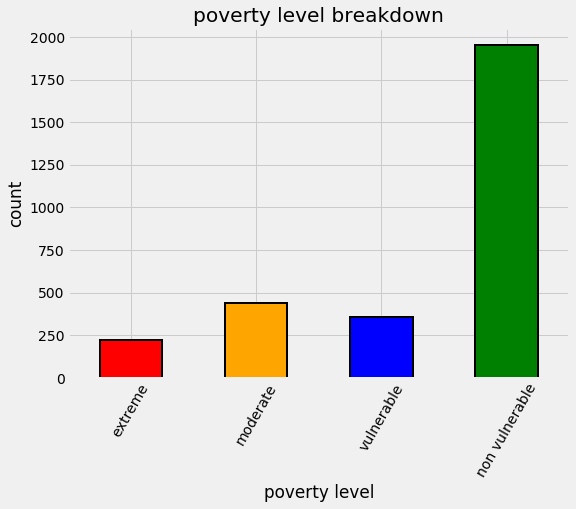

In [537]:
# 가장(head of household) 추출
heads = data.loc[data['parentesco1'] == 1].copy()

# 학습데이터의 라벨
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1'] == 1), ['Target', 'idhogar']]

# Target의 값별 카운팅
label_counts = train_labels['Target'].value_counts().sort_index()

# 각 라벨 별 데이터 개수 - barplot
label_counts.plot.bar(figsize=(8, 6), color=colors.values(),
                     edgecolor='k', linewidth=2)
plt.xlabel('poverty level')
plt.ylabel('count')
plt.xticks([x-1 for x in poverty_mapping.keys()],
          list(poverty_mapping.values()), rotation=60)
plt.title('poverty level breakdown')

label_counts

우리는 불균형한 클래스 문제를 다루고 있다. (이 문제는 대회 주최자들이 f1이 아닌 Macro f1 점수를 평가 지표로 정했는지를 흥미롭게 만든다.) 다른 어떤 카테고리 보다도 취약하지 않은 가구로 분류되는 가구의 수가 더 많다. 극도의 빈곤층은 가장 적다. 

불균형 분류 문제의 한 가지 문제점은 데이터가 훨씬 적기 때문에 머신러닝 모델이 소수 계층을 예측하는 데 어려움을 겪을 수 있다는 점이다. 인간의 관점에서 생각해보자: 만약 우리가 가난 정도를 분류하고 있는데, 극도로 빈곤한 경우보다 빈곤하지 않은 경우가 훨씬 많아보인다면, 이는 우리가 적게 보았기 때문에(less exposure) 극도로 빈곤한 가구를 식별하는 것을 더 어렵게 할 것이다. 클래스 불균형 문제를 해결할 수 있는 잠재적인 방법은 오버샘플링을 하는 것이다.

### 2.7. Addressing Wrong Labels
현실적인 데이터셋과 마찬가지로, Costa Rican 빈곤 데이터도 몇 가지 문제가 있다. 일반적으로 데이터 사이언스 프로젝트의 80%는 데이터를 클렌징하고 이상치나 오류를 수정하는데 사용한다. 이러한 오류는 인간(데이터 입력하는 사람)의 입력 오류, 측정 오류 또는 때로는 정확하지만 눈에 띄는 극단적인 값일 수 있다. 이 문제에 대해, 같은 가구에 있는 개개인의 빈곤 정도가 다르기 때문에 일부 라벨은 정확하지 않다. 왜 이런 일이 일어났는지는 알 수 없지만, 가장을 진짜 라벨로 사용하라는 말일 것이다.

그 정보는 우리의 일을 더 쉽게 만들지만, 현실의 문제에서 왜 라벨이 잘못된 것인지 그리고 어떻게 이 문제를 스스로 해결할 것인지 알아내야 한다. 이 절에서는 꼭 필요하지는 않지만 라벨에 관련된 문제를 해결할 것이다: 이런 문제를 마주할 때 어떻게 다뤄야하는지 보여주기 위해 이 Notebook에 씀.

#### 2.7.1. Identify Errors
먼저 에러를 고치기 전에 에러를 확인할 필요가 있다. 가족 고성원에 대한 라벨이 다른 가구를 찾기 위해, 가구별로 데이터를 그룹화한 다음 Target의 고유값이 하나만 있는지 확인을 한다.

In [538]:
# 가구를 그룹화하여 고유값의 개수를 확인
all_equal = train.groupby('idhogar')['Target'].apply(lambda x:x.nunique() == 1)

# Target 값이 같지 않은 가구들
not_equal = all_equal[all_equal != True]
print('가족 구성원 끼리 같은 Target 값을 갖지 않는 가구는 총 {}가구이다.'.format(len(not_equal)))

가족 구성원 끼리 같은 Target 값을 갖지 않는 가구는 총 85가구이다.


In [539]:
train[train['idhogar'] == not_equal.index[0]][['idhogar', 'parentesco1', 'Target']]

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


주최측은 우리에게 정확한 라벨은 여기서 `parentescol==1`인 가장의 것이라고 말하고 있다. 이 가구의 경우, 모든 구성원에 대한 올바른 라벨은 3이다. 이 가정의 모든 개인에게 올바른 Target 값을 할당함으로써 이 문제를 해결할 수 있다. 현실 세계에서, 여러분은 그 문제를 어떻게 해결해야 하는지에 대한 어려운 결정을 스스로 내려야할지 모른다. (혹은 팀의 도움을 받아서)

#### 2.7.2. Families without Heads of Household

우리는 같은 가구 내의 가장의 라벨로 통일함으로써 라벨 불일치 문제를 해결할 수 있다. 하지만 잠깐, 여러분은 아마 이렇게 물을지도 모른다, "만약 가장이 없는 가구가 있다면? 그리고 만약 그 가구들의 구성원들이 각각 다른 라벨 값을 가지고 있다면?"

음, 네가 물어봤으니, 그 질문을 정확히 조사해보자!

In [540]:
# 가장인 로우 추출
households_leader = train.groupby('idhogar')['parentesco1'].sum()

# 가장이 없는 가구 추출
households_no_head = train.loc[train['idhogar'].isin(
    households_leader[households_leader == 0].index), :]

print('가장이 없는 가구는 총 {}가구이다.'.format(households_no_head['idhogar'].nunique()))

가장이 없는 가구는 총 15가구이다.


In [541]:
# 가장이 없는 가구의 라벨이 다른지 확인
households_no_head_equal = households_no_head.groupby(
    'idhogar')['Target'].apply(lambda x: x.nunique() == 1)
print('가장이 없는 가구 중 {}가구가 다른 라벨 값을 가지고 있다.'.format(
    sum(households_no_head_equal == False)))

가장이 없는 가구 중 0가구가 다른 라벨 값을 가지고 있다.


정말 다행히 가장이 없는 가구의 구성원들의 라벨 값이 다른 경우가 없다는 것을 볼 수 있다. 이 문제에 대해 주최측에 따르며, 만약 한 가정에 가장이 없다면, 진정한 라벨값은 없다고 한다. 따라서, 우리는 실제로 학습에 가장이 없는 가구는 사용하지 않을 것이다. 그럼에도 불구하고 데이터를 조사하는 과정은 여전히 좋은 연습이다.

#### 2.7.3. Correct Errors
이제 우리는 가족 구성원이 다른 빈곤 정도를 가지고 가장이 있는 가구의 라벨을 고칠 수 있다.

In [542]:
for household in not_equal.index:
    # 가장의 Target값 추출
    true_target = int(train[(train['idhogar'] == household) & (train['parentesco1'] == 1.0)]['Target'])
    
    # 해당 가정의 모든 구성원이 같은 라벨 값을 갖도록 수정
    train.loc[train['idhogar'] == household, 'Target'] = true_target
    
# 가구를 기준으로 그룹화하고 라벨값이 모두 동일한지 확인
all_equal = train.groupby('idhogar')['Target'].apply(lambda x:x.nunique() == 1)

# 같은 타켓값을 갖지 않는 가구수
not_equal = all_equal[all_equal != True]
print('구성원 모두가 같은 Target값을 갖지 않는 가구수는 총 {}가구이다.'.format(len(not_equal)))

구성원 모두가 같은 Target값을 갖지 않는 가구수는 총 0가구이다.


우리는 라벨값을 위해 가장이 있는 가구만 사용하기 때문에 이 단계는 꼭 필요하지는 않다. 하지만 실제로 만날만한 데이터 에러를 고치는 워크플로우를 보여주었다. 잡일이라 생각하지 말고, 커리어를 위해 연습해라.

### 2.8. Missing Values
eda에서 가장 중요한 단계는 데이터에서 결측치를 찾아서 이를 어떻게 다룰지 결정하는 것이다. 결측치는 머신러닝 모델에 사용하기 전에 꼭 채워야 하며 피처를 바탕으로 이 값을 가장 잘 채울 수 있는 방법을 생각할 필요가 있다: 여기서 데이터의 정의를 파해칠 필요가 있다.

먼저 각 컬럼별 결측치의 비율을 살펴보자.

In [543]:
# 각 컬럼의 결측치의 개수
missing = pd.DataFrame(data.isnull().sum()).rename(columns={0:'total'})

# 결측치 비율 컬럼 생성
missing['percent'] = missing['total'] / len(data)

# 비율을 기준으로 역정렬
missing.sort_values('percent', ascending=False).head(10).drop('Target')

,total,percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


우리는 `Target`에 대해서는 걱정할 필요가 없다. 왜냐하면 테스트 데이터를 위해 NaN값을 만들었기 때문이다. 하지만, 우리는 결측치 비율의 상위권에 위치한 이 3개의 컬럼을 처리할 필요가 있다.

**v18q1** : 태블릿의 개수

가정이 소유하고 있는 타블릿의 개수를 나타내는 `v18q1`부터 시작해보자. 우리는 이 변수의 값 별 개수를 살펴볼 수 있다. 이 변수는 가정에 대한 변수이기 때문에, 가정 수준에서 바라봐야 타당하다. 그러므로 우리는 가장에 해당하는 로우만 추출할 것이다.

#### 2.8.1. Function to Plot Value Counts
각 컬럼별 값의 개수를 plot하기 위해 간단한 함수를 정의하였다.

In [544]:
# 컬럼의 값별 개수를 계산하고 분포를 barplot으로 그림
def plot_value_counts(df, col, heads_only=False):
    # 가장 추출
    if heads_only:
        df = df.loc[df['parentesco1'] == 1].copy()
    
    plt.figure(figsize=(8, 6))
    df[col].value_counts().sort_index().plot.bar(color='blue',
                                                edgecolor='k',
                                                linewidth=2)
    plt.xlabel(f'{col}')
    plt.title(f'{col} value counts')
    plt.ylabel('count')
    
    plt.show()

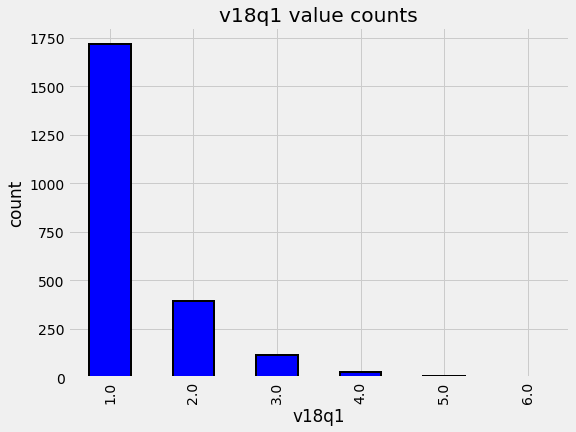

In [545]:
plot_value_counts(heads, 'v18q1')

존재하는 데이터만 가지고 본다면 소유하고 있는 타블릿의 개수 중 가장 흔한 수는 1로 보인다. 다만 결측치를 생각해볼 필요가 있다. 이 경우, 이 카테고리에서 NaN을 가진 가정은 태블릿을 소유하지 않을 수도 있다! 이 데이터의 정의를 살펴보면 `v18q`는 한 가족이 태블릿을 소유하는지 여부를 나타내는 것으로 볼 수 있다. 우리는 이 컬럼과 태블릿의 수를 결합하여 살펴보아 우리의 가설이 맞는지 확인해봐야 한다.

우리는 `v18q`의 값을 (태블릿을 갖는 경우 1, 아닌 경우 0)으로 그룹화한 다음 `v18q1`의 null값을 계산해보자. 이는 null값은 가족이 태블릿을 갖지 않는지를 말해줄 것이다.

In [546]:
# v18q1이 NaN인 가정의 v18q(태블릿 소유여부)가 0인지 확인 
heads.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

v18q
0    8044
1       0
Name: v18q1, dtype: int64

이것이 문제를 풀어주었다! `v18q1`이 NaN인 가족들은 테블릿을 가지고 있지 않는다. 그러므로, 우리는 결측치를 0으로 채울 필요가 있다.

In [547]:
data['v18q1'] = data['v18q1'].fillna(0)

**v2a1** : 월세 납부액

다음 결측치가 있는 컬럼인 `v2a1`이다.

월세 납부의 결측치를 살펴보는 것 외에 주택의 소유/임대 현황을 보여주는 컬럼인 `tipovivi_`의 분포도 살펴보자. 이 그림에서는 월세 납부에서 NaN을 가진 가구의 집의 소유 현환을 보여준다.

Text(0.5, 1.0, 'home ownership status for households missing rent payments')

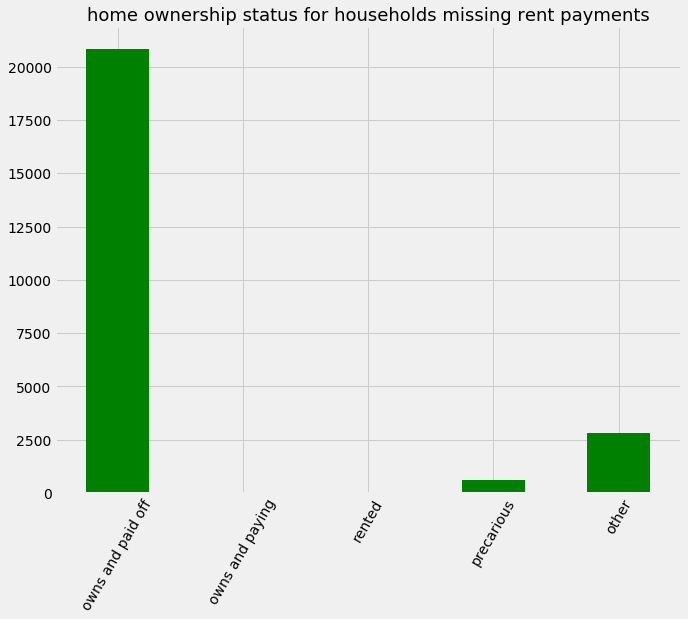

In [548]:
# 집 소유 여부를 나타내는 피처
own_variables = [x for x in data if x.startswith('tipo')]

# 임대료가 누락된 집에 대한 집 소유 변수의 분포 - barplot
data.loc[data['v2a1'].isnull(), own_variables].sum().plot.bar(figsize=(10, 8), color='green',
                                                              ecolor='k', linewidth=2)
plt.xticks([0, 1, 2, 3, 4], ['owns and paid off', 'owns and paying',
                             'rented', 'precarious', 'other'], rotation=60)
plt.title('home ownership status for households missing rent payments', size=18)

집 소유 변수의 의미는 다음과 같다:
* `tipovivi1=1` : 소유 및 완전히 개인 소유
* `tipovivi2=1` : 소유 및 할부로 지불
* `tipovivi3=1` : 임대
* `tipovivi4=1` : 불안정
* `tipovivi5=1` : 기타(대여, 할당)

우리는 이 문제를 풀었다! 음 대부분 월세를 내지 않는 가정들은 일반적으로 자신의 집을 소유하고 있다. 다른 몇 가지 상황에서는 정보가 누락된 이유를 알 수가 없다.

월세 납부액이 누락된 소유 주택에 대해서는 임대료 납부액을 0으로 설정하면 된다. 다른 가정에서는 결측치를 채우도록(imputed) 나둘 수 있지만 이 가정이 결측치를 가진 가정임을 나타내는 flag(불리언) 컬럼을 추가해줄 것이다.

In [549]:
# 집을 소유하고 있는 가정의 월세납부액을 0으로 채움
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

# 월세 납부액 누락 여부를 나타내는 컬럼 생성
data['v2a1-missing'] = data['v2a1'].isnull()
data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

**rez_esc** : 학교를 떠난 후의 년수

결측치 비율이 가장 높은 마지막 컬럼인 `rez_esc`는 학교를 떠난 후의 년수을 뜻한다. null값을 가진 가정은 현재 학교를 다니는 자녀가 없을 가능성이 있다. 이 컬럼에서 결측치를 가지고 있는 개인의 나이와 결측치를 가지고 있지 않은 개인의 나이를 살펴보자.

In [550]:
data.loc[data['rez_esc'].notnull()]['age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

이는 우리에게 결측치를 가진 개인의 가장 높은 나이는 17임을 보여준다. 이보다 높은 값을 가진다면 우리는 이들은 학교에 있지 않는다고 가정할 수 있다. 이제 결측치를 가진 데이터의 나이를 살펴보자.

In [551]:
data.loc[data['rez_esc'].isnull()]['age'].describe()

count    27581.000000
mean        39.110656
std         20.983114
min          0.000000
25%         24.000000
50%         38.000000
75%         54.000000
max         97.000000
Name: age, dtype: float64

만약 네가 대회의 discussion(토론)을 살펴보았다면 이 변수는 오직 7살 이상 그리고 19살 이하의 개인에게만 정의되어 있음을 알 수 있다. 이 범위보다 더 어리거나 많은 사람은 아마도 몇 년 뒤처지지 않으며 따라서 그 값은 0으로 설정되어야 한다. 이 변수의 경우, 19살을 초과하여 결측치를 가지거나 7살보다 어려 결측치를 가진다면 우리는 이 값을 다 0으로 세팅할 수 있다. 다른 사람들을 위해 우리는 이 값을 채우기(impute)하기 위해 놔두고 불리언 flag 변수를 추가할 것이다.

In [552]:
# 19살 초과 혹은 7살 미만이고 rez_esc가 결측치를 가진 경우 0으로 설정
data.loc[((data['age'] > 19) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

# 결측치를 가진 7과 19살 사이의 데이터에 대해 플래그(flag) 추가
data['rez_esc-missing'] = data['rez_esc'].isnull()

rez_esc 컬럼에 하나의 이상치를 찾아 볼 수 있습니다. 디스커션을 읽었다면 해당 값의 최대치는 5입니다. 따라서 5의 값을 넘는 것들에게 모두 5를 할당해 줍시다

In [553]:
data['rez_esc'].describe()

count    32252.000000
mean         0.078631
std          0.693136
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         99.000000
Name: rez_esc, dtype: float64

### 2.9. Plot Two Categorical Variables

두 개의 카테고리컬한 변수들에 대해서 시각화하는 방법에는: 산포도, 박스그림 등이 있습니다.

저자는 위의 시각화 중 어떤 것도 만족하지 않아서 아래의 함수를 정의하였다. 이 함수는 기본적으로 두 카테고리의 scatterplot으로, 각 카테고리의 점의 크기가 각 x값으로 대표되즞 주어진 y값의 비율을 나타낸다.

In [554]:
# 두 개의 카테고리형 변수를 시각화 - scatterplot
def plot_categoricals(x, y, data, annotate=True):
    # 정규화 하기 전의 카운트 데이터
    # 1. y를 기준으로 그룹화
    # 2. 그 때의 x의 값에 따른 개수 카운팅
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize=False))
    raw_counts = raw_counts.rename(columns={x: 'raw_count'})
    
    # 정규화한 후의 카운트 데이터
    # x와 y의 각 그룸별 개수 카운팅
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize=True))
    
    # 컬럼 명을 바꾸고 인덱스 순서 리셋
    counts = counts.rename(columns={x:'normalized_count'}).reset_index()
    counts['percent'] = 100 * counts['normalized_count']
    
    # 정규화전 데이터인 raw_count 추가
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize=(14, 10))
    
    # 퍼센트를 기준으로 각 그룹별 분포 - scatterplot
    plt.scatter(counts[x], counts[y], edgecolor='k', color='lightgreen',
               s=100*np.sqrt(counts['raw_count']), marker='o',
               alpha=0.6, linewidth=1.5)
    
    if annotate:
        # 그림(plot)에 주석달기
        for i, row in counts.iterrows():
            # 적절한 오프셋(offset) 텍스트 삽입
            plt.annotate(xy=(row[x] - (1/counts[x].nunique()),
                            row[y] - (0.15/counts[y].nunique())),
                        color='navy',
                        s=f"{round(row['percent'], 1)}%")
    
    plt.yticks(counts[y].unique())
    plt.xticks(counts[x].unique())
    
    # 최소 최대값을 제곱근으로 변환
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))
    
    # 범례를 5가지로 구분
    msizes = list(range(sqr_min, sqr_max,
                        int(( sqr_max - sqr_min) / 5)))
    markers = []
    
    # 범례의 마커(marker)
    for size in msizes:
        markers.append(plt.scatter([], [], s = 100 * size, 
                                   label = f'{int(round(np.square(size) / 100) * 100)}', 
                                   color = 'lightgreen',
                                   alpha = 0.6, edgecolor = 'k', linewidth = 1.5))
        
    # 범례 및 포맷팅
    plt.legend(handles = markers, title = 'Counts',
               labelspacing = 3, handletextpad = 2,
               fontsize = 16,
               loc = (1.10, 0.19))
    
    plt.annotate(f'* Size represents raw count while % is for a given y value.',
                 xy = (0, 1), xycoords = 'figure points', size = 10)
    
    # 축 한계 조정
    plt.xlim((counts[x].min() - (6 / counts[x].nunique()), 
              counts[x].max() + (6 / counts[x].nunique())))
    plt.ylim((counts[y].min() - (4 / counts[y].nunique()), 
              counts[y].max() + (4 / counts[y].nunique())))
    
    plt.grid(True)
    plt.xlabel(f"{x}")
    plt.ylabel(f"{y}")
    plt.title(f"{y} vs {x}")

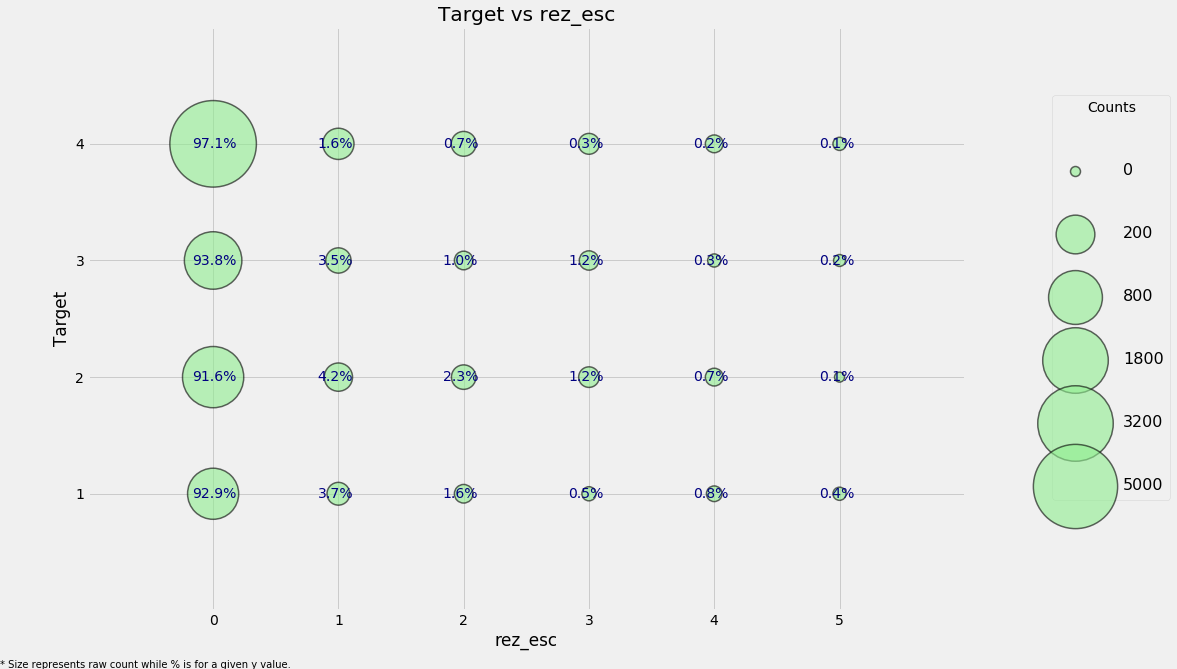

In [555]:
plot_categoricals('rez_esc', 'Target', data)

하나의 점의 크기는 개수를 뜻합니다. 표를 읽으려면, 임의의 세로축 값을 고르고 가로로 하나씩 읽으면 됩니다. 예를들면 빈곤단계가 1인경우에는, 93퍼센트의 개개인이 years behind가 0이며 이 크기는 대략 800명 정도 된다는 것을 의미합니다.

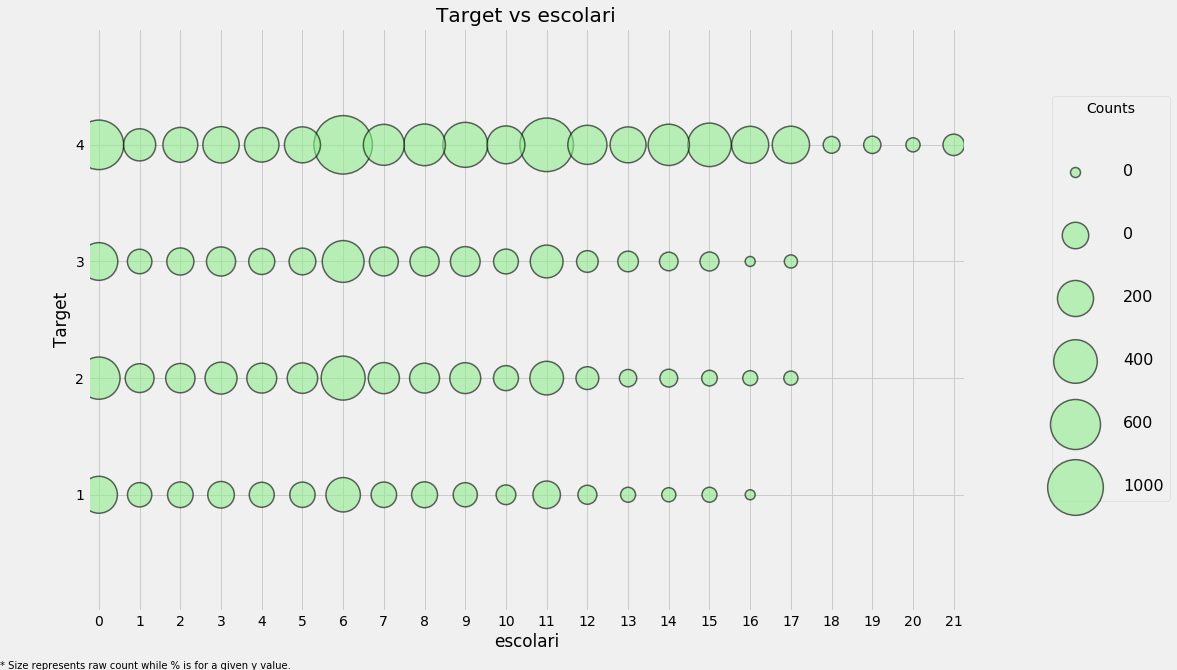

In [556]:
plot_categoricals('escolari', 'Target', data, annotate=False)

남은 각 컬럼의 손실 값들은 Imputation이라고 거치는 손실 값을 채우는 과정을 거치게 될 것입니다. 몇몇의 imputation 타입은 주로 사용되며, 그중 가장 간단하고 효과적인 방법은 중앙값을 넣는 것입니다.

손실값의 마지막 단게로서, 우리는 손실값들의 타겟 라벨의 분포를 그려볼 것입니다.

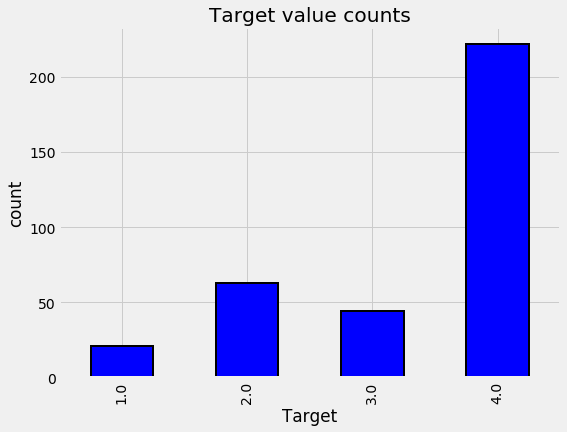

In [557]:
plot_value_counts(data[(data['rez_esc-missing'] == 1)], 'Target')

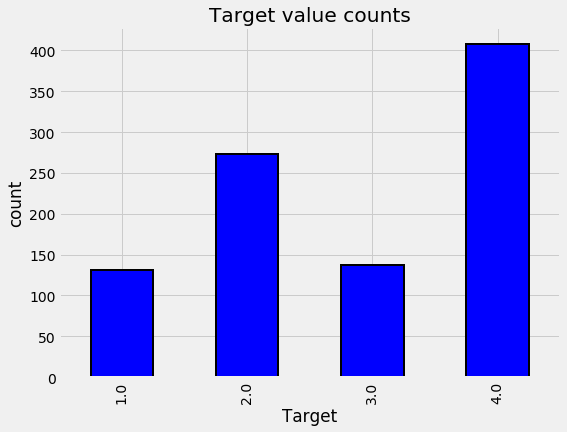

In [558]:
plot_value_counts(data[(data['v2a1-missing'] == 1)], 'Target')

이는 2: 온건한 빈곤의 유병률이 높은 것을 감안하면 더 많은 빈곤을 보여주는 지표로 보인다.
가끔은 손실 값들이 중요한 정보를 가지고 있다는 것을 보여주기도 합니다.

## 3. Feature Engineering
우리가 할 수 있는 EDA는 굉장히 많지만, 우리의 데이터들을 가구당 단위로 합병하는 작업을 진행해야합니다. 우리는 각각의 가구별 정보를 조금 가지고 있지만, 훈련을 위해서는 각각의 가구를 위해 정보를 간략화할 필요가 있습니다. 이는 개개인을 가구별로 그룹을 짓고 개별 값을 병합해야합니다.

필자는 feature engineering에 있어서 자동화된 방법을하려고 하며, 이러한 방법은 머신러닝 작업 흐름에서 굉장히 기본적인 부분입니다. 우리는 수작업으로 할 것이지만, 자동적으로 하는 방법을 꼭 참고해보시길 바랍니다.

### 3.1. Column Definitions

데이터 사이언스에서 우리는 직접 데이터에서 무언가를 찾아내야하고 시간이 많이걸리는 지루한 작업들을 해야할 수 있습니다. 이것은 분석의 단계입니다: 각각의 컬럼을 정의하고 어느 것이 **개개인의 수준인가 또는 가구별 수준인지** 설명을 통해 알아내야합니다. 데이터 설명을 보지 않고서는 이것을 밝혀낼만한 다른 방법은 없을 것입니다. 필자는 이미 작업을 해두었으니, 해야할 일은 가져다 쓰는 것입니다. 다른 방법으로 몇몇이 사용되기 때문에 이들을 위해 몇몇의 다른 변수를 선언할 것입니다. 각각의 레벨에서 쓰여질 변수들이 정의되고 난 뒤에, 이를 사용하기 위해서 병합을 시작할 것입니다.

해당 과정은 아래의 과정과 같습니다.

1. 변수를 가구단위 와 개별단위로 구분한다.
2. 개개인 수준의 데이터를 위해서 적절한 병합방법을 찾습니다. Ordinal 값들은 통계적 병합에 사용될 것이며 논리형 자료들은 적은 통계치들에 병합될 것이다.
5. 개인 수준의 데이터를 가구별 수준의 데이터에 합친다.

### 3.2. Define Variable Categories

변수마다 여러 종류의 카테고리가 존재한다:
1. 개인 변수들 : 가정보다는 각 개인의 특성을 말한다.
    * 불리언: Yes or No (0 or 1)
    * 순서가 있는 이산적인 수
2. 가정 변수들
    * 불리언: Yes or No (0 or 1)
    * 순서가 있는 이산적인 수
    * 연속적인 수
3. 제곱 변수들 : 데이터의 제곱 변수들
4. Id 변수들 : 데이터를 분류하기 위함. 피처로 사용하지는 않는다.

아래에 우리는 각각의 카테고리의 변수들을 정의해두었습니다.

In [559]:
# 개인(Individual) 변수
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

In [560]:
# 가구(Household) 변수
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

In [561]:
# 제곱 변수
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

In [562]:
# ID 변수
id_ = ['Id', 'idhogar', 'Target']

혹시 반복되는 것은 없는지 확인해봅시다.

In [563]:
x = ind_bool + ind_ordered + hh_bool + hh_ordered + hh_cont + sqr_ + id_

In [564]:
from collections import Counter

print('중복되는 변수가 없다 :', np.all(np.array(list(Counter(x).values())) == 1))
print('모든 변수를 커버한다 :', len(x) == data.shape[1])

중복되는 변수가 없다 : True
모든 변수를 커버한다 : True


### 3.3. Squared Variables
가장 쉬운 방법으로, 우리는 모든 이와 같은 값들을 지울 수 있습니다. 그러나 가끔씩 우리는 이러한 성격을 지닌 값들이 비선형관계를 선형모델이 학습을 하도록 도와주기 때문에 사용합니다. 그러나 더욱 더 복잡한 모델을 사용할 것이기 때문에, 위와 같은 특징들은 중복이 됩니다. 이 값들은 제곱이 취해지기 전의 컬럼과 굉장히 높은 상관관계를 보이며, 이는 더 나아가 우리의 모델에 이롭지 않을 수 있습니다.

예시로 알아봅시다.

Text(0.5, 1, 'squared age vs age')

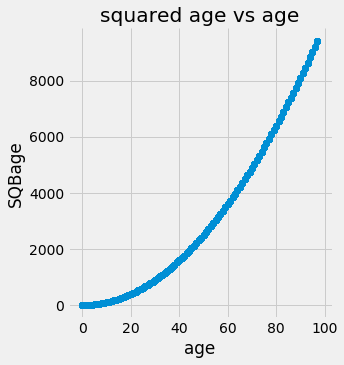

In [565]:
sns.lmplot('age', 'SQBage', data=data, fit_reg=False)
plt.title('squared age vs age')

위와 같이 이러한 성격의 값은 굉장히 상관관계가 커서 둘 다 모두를 데이터셋에 남겨둘 필요가 없습니다.

In [566]:
data = data.drop(columns=sqr_)
data.shape

(33413, 136)

### 3.4. Id Variables
Id 값은 각각을 식별하기 위해 반드시 필요하므로 삭제등을 하지 않습니다.

### 3.5. Household Level Variables
가장들의 서브셋을 만들고 가구별 컬럼들을 추출합니다.

In [567]:
heads = data.loc[data['parentesco1']==1, :]
heads = heads[id_ + hh_bool + hh_cont + hh_ordered]
heads.shape

(10307, 99)

대부분의 가구별 수준의 변수들에 대해, 우리가 가구별로 예측을 하려고 할 때에는 위의 변수들을 사용합니다. 그러나 이 데이터들에서도 중복되는 값들을 제거해야 하며 몇몇의 특징들은 존재하는 데이터로부터 파생된 경우가 있습니다.

#### 3.5.1. Redundant Household Variables

가구단위의 변수들의 상관관게를 알아보도록 합시다. 만약 너무 많이 높은 상관관계를 보이는 것이 있다면, 우리는 그 쌍중 하나를 삭제할 필요가 있습니다. 다음의 코드는 절대값 0.95이상의 상관관게를 가지는 변수들을 알아내는 코드입니다.

In [568]:
# 상관관계 행렬 생성
corr_matrix = heads.corr()
# 위쪽 삼격형 모양 선택
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# 상관관계까 0.95보다 큰 피처들의 인덱스 추출
# 굳이 any를 한 번 더 쓰는 이유는?
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]
to_drop

['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

관련된 변수의 각각의 쌍중 하나를 보여줌. 다른 쌍을 찾기위해서는 corr_matrix를 만들어야 한다.

In [569]:
corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9]

,r4t3,tamhog,tamviv,hhsize,hogar_total
r4t3,1.000000,0.998287,0.910457,0.998287,0.998287
tamhog,0.998287,1.000000,0.909155,1.000000,1.000000
tamviv,0.910457,0.909155,1.000000,0.909155,0.909155
hhsize,0.998287,1.000000,0.909155,1.000000,1.000000
hogar_total,0.998287,1.000000,0.909155,1.000000,1.000000


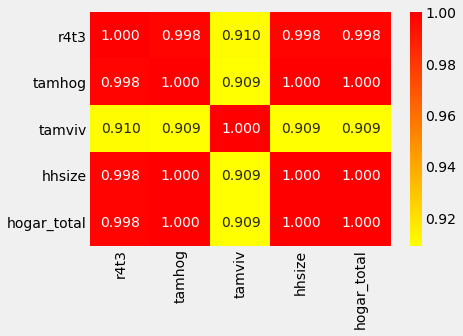

In [570]:
sns.heatmap(corr_matrix.loc[corr_matrix['tamhog'].abs(
) > 0.9, corr_matrix['tamhog'].abs() > 0.9], annot=True, cmap=plt.cm.autumn_r, fmt='.3f')

"tamhog는 가구의 사이즈를 뜻함"

집의 사이즈와 관련 있는 변수들은 아래와 같습니다.

* `r4t3`: 집에 살고 있는 총인원 수
* `tamhog`: 가구의 크기
* `tamviv`: 가구에 실제로 살고 있는 사람의 수
* `hhsize`: 가구의 크기
* `hogar_total`: 가구에 있는 개별 인원의 총합

이러한 값들은 서로 큰 연관성을 가지고 있습니다. 실제로 hhsize는 tamhog나 hogar_total과 완벽한 선형성을 보여줍니다. 이 정보는 중복이기 때문에 두 변수를 제거해 줄 것입니다. r4t3또한 거의 완벽한 중복에 가깝기 때문에 지워줄 것입니다. 

tamviv는 hhsize와 필수적으로 같을 필요는 없습니다. 왜냐하면 가구에 살고 있지 않는 가족들도 있기 때문이죠. 그 차이를 scatterplot으로 시각화해봅시다.

In [571]:
heads = heads.drop(columns=['tamhog', 'hogar_total', 'r4t3'])

Text(0.5, 1, 'household size vs number of persons living in the household')

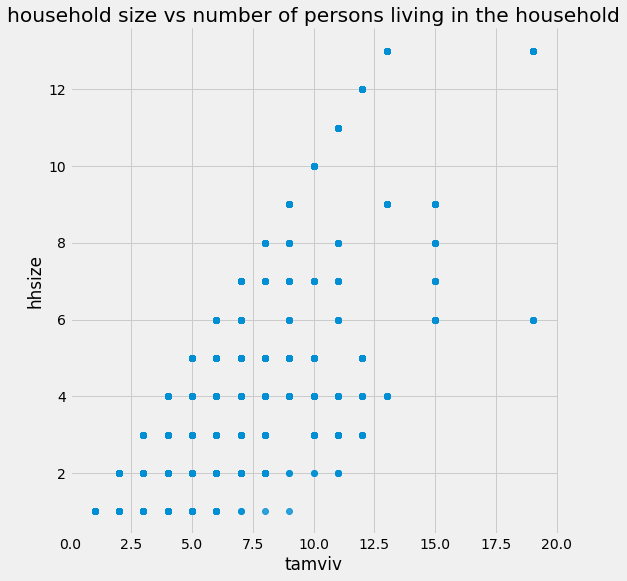

In [572]:
sns.lmplot('tamviv', 'hhsize', data, fit_reg=False, size=8)
plt.title('household size vs number of persons living in the household')

우리는 다양한 케이스들을 봤고, 가족의 수보다 가구에 살고 있는 사람들이 많습니다. 이는 우리가 두 인원의 차이를 새로운 feature로 쓰는 인사이트를 제공합니다.

새로운 feature를 만들어 봅시다.

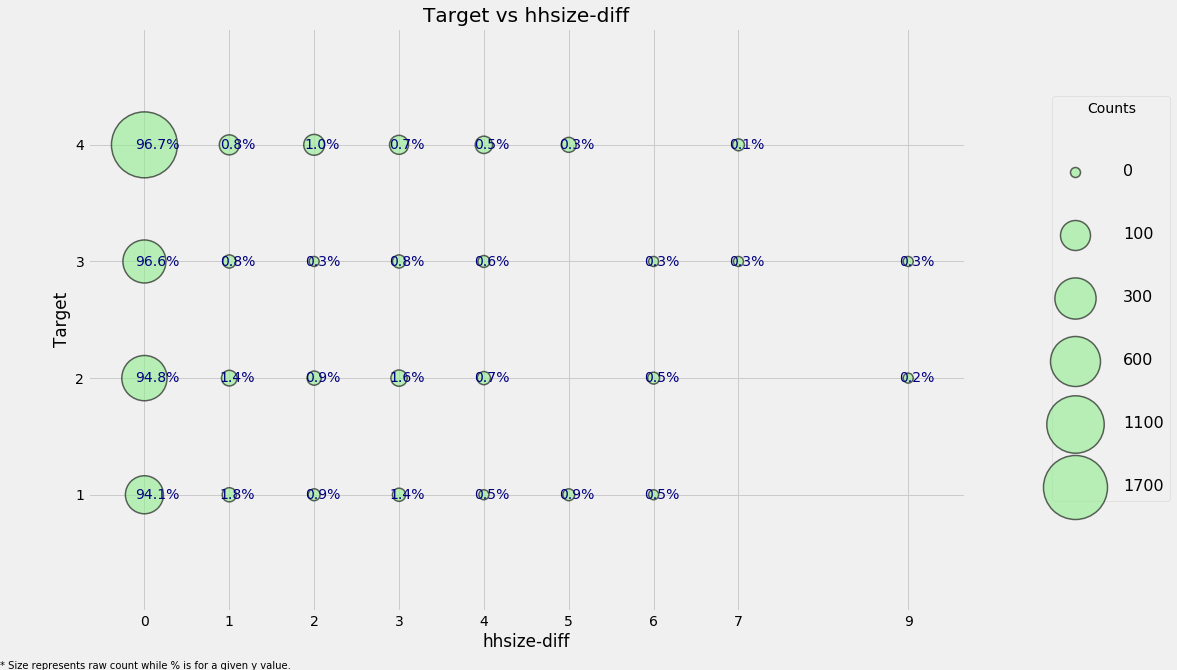

In [573]:
# 0이면 가구수 = 실제 실거주자 수가 같은 것임
heads['hhsize-diff'] = heads['tamviv'] - heads['hhsize']
plot_categoricals('hhsize-diff', 'Target', heads)

비록 많은 가구들이 차이를 가지고 있지 않더라도, 몇몇의 차이가 나는 가구들이 존재합니다. 이제는 다른 변수 `elec`으로 넘어가 봅시다.

In [574]:
corr_matrix.loc[corr_matrix['coopele'].abs() > 0.9, corr_matrix['coopele'].abs() > 0.9]

,public,coopele
public,1.000000,-0.967759
coopele,-0.967759,1.000000


이 변수들은 집의 전기가 어디서 오는지를 가르킵니다. 여기에는 네가지 옵션이 있습니다. 그리고 전기가 없거나(noelec) 개인 발전을 하는 선택지(planpri)를 동시에 선택할 수 없습니다.

#### 3.5.2. Creating Ordinal Variable

네가지 컬럼을 하나로 합칠 것입니다. 합치는 데 있어서 매핑은 아래와 같습니다.
* 0: No electricity
* 1: Electricity from cooperative
* 2: Electricity from CNFL, ICA, ESPH/JASEC
* 3: Electricity from private plant

순서형 변수는 고유한 순서를 가지고 있다. 이를 위해 우리는 우리의 도메인 지식을 가지고 선택한다. 이를 통해 하나의 컬럼을 만들면 다른 컬럼들을 없애줍니다. 만약 값이 없다면 나중에 채워줄 것이므로 해당하는 값을 구분하기 위해서 논리형 컬럼을 추가하여줍니다.

In [575]:
elec = []

for i, row in heads.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)

In [576]:
heads['elec'] = elec
heads['elec-missing'] = heads['elec'].isnull()
heads = heads.drop(columns=['noelec', 'coopele', 'public', 'planpri'])

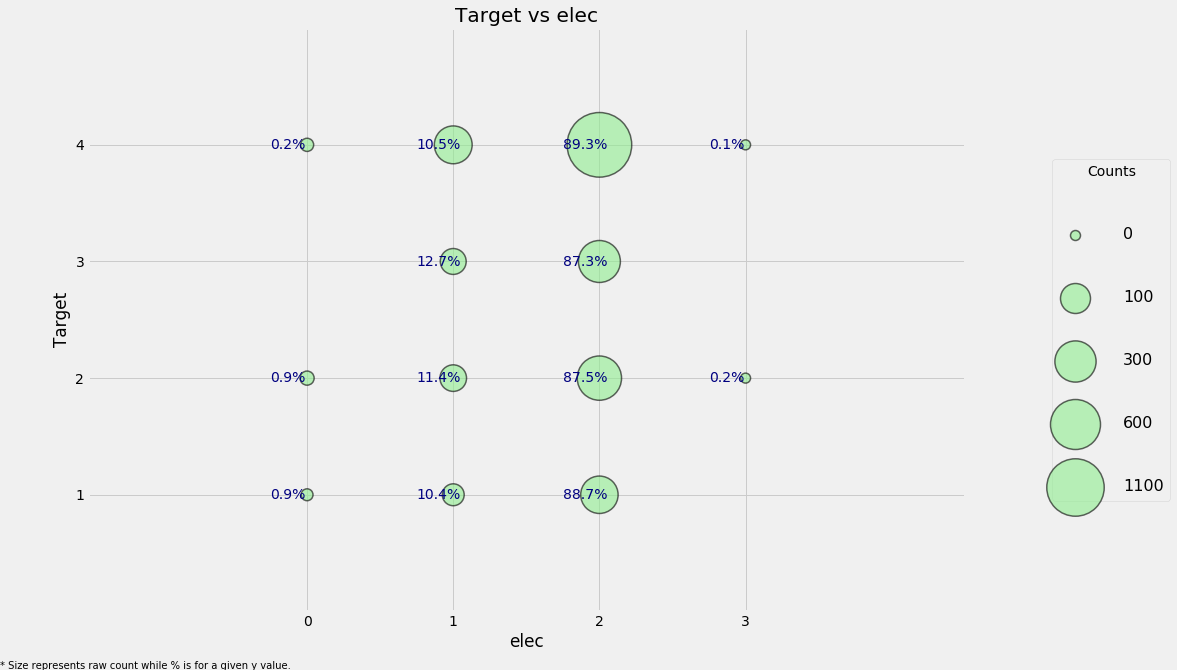

In [577]:
plot_categoricals('elec', 'Target', heads)

그림에서도 볼 수 있듯이 가장 평범한 방법은 공식적인 공급자에게 받는 것입니다.

마지막 컬럼은 `area2`입니다. 이 컬럼은 집이 교외에 있는지를 물어보는 것입니다. 그러나 이미 집이 도심에 있는지에 대한 컬럼이 있기 때문에 해당 컬럼은 중복되었다고 할 수 있습니다. 그러므로 해당 컬럼을 제거합니다.

In [578]:
corr_matrix.loc[corr_matrix['area2'].abs() > 0.9, corr_matrix['area2'].abs() > 0.9]

,area1,area2
area1,1.0,-1.0
area2,-1.0,1.0


In [579]:
heads = heads.drop(columns='area2')
heads.groupby('area1')['Target'].value_counts(normalize=True)

area1  Target
0      4.0       0.582249
       2.0       0.176331
       3.0       0.147929
       1.0       0.093491
1      4.0       0.687030
       2.0       0.137688
       3.0       0.108083
       1.0       0.067199
Name: Target, dtype: float64

위에 의하면 도심에 사는 가구가 취약계층들을 별로 가지고 있는 것을 알 수 있습니다.

#### 3.5.3. Creating Ordinal Variables
집의 벽, 지붕, 바닥에 대해 세개의 컬럼이 있습니다. 우리는 이들을 논리형으로 남길 수 있습니다. 하지만 필자는 이를 순서형으로 나쁨 보통 좋음 순으로 바꾸었으면 합니다. 이를 위해 `np.argmax`를 사용하여 가 가구에 대해 0이 아닌 열을 간단히 찾을 수 있다.

일단 서수형 변수를 만들면, 원래의 변수를 제거할 수 있다.

In [580]:
heads[['epared1', 'epared2', 'epared3']]

,epared1,epared2,epared3
0,0,1,0
1,0,1,0
2,0,1,0
5,0,0,1
8,1,0,0
...,...,...,...
33393,0,1,0
33398,1,0,0
33400,0,1,0
33404,1,0,0


In [581]:
np.array(heads[['epared1', 'epared2', 'epared3']])

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1]], dtype=int64)

In [582]:
# 서수형 변수 wall
heads['wall'] = np.argmax(np.array(heads[['epared1', 'epared2', 'epared3']]), axis=1)
heads = heads.drop(columns=['epared1', 'epared2', 'epared3'])
heads['wall'].head()

0    1
1    1
2    1
5    2
8    0
Name: wall, dtype: int64

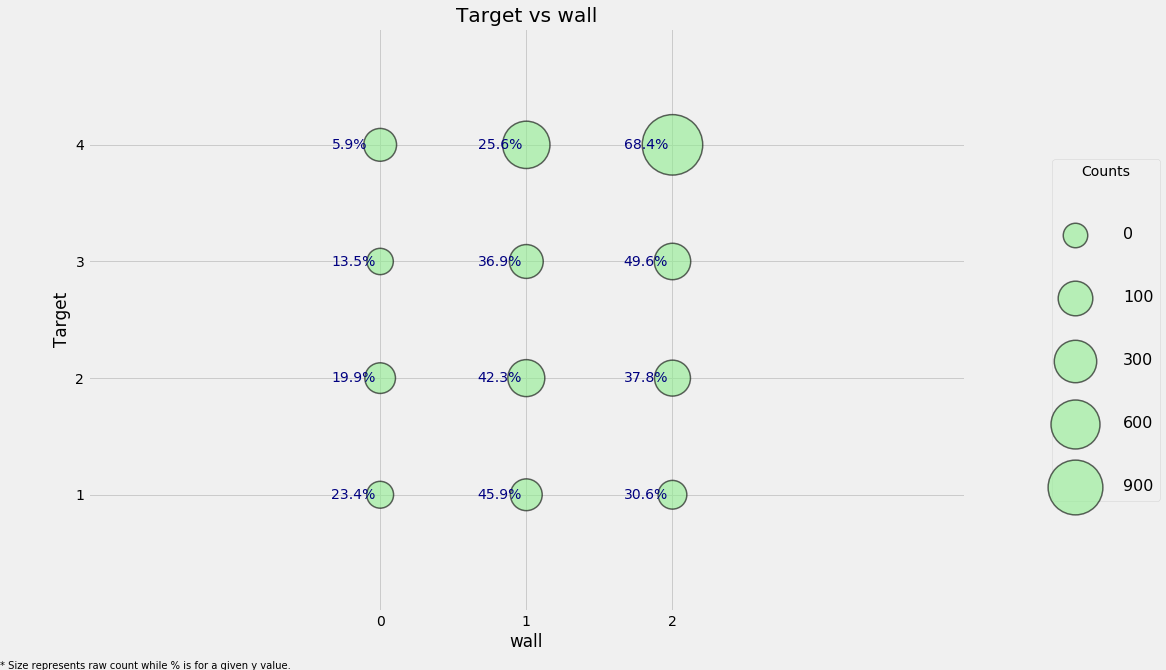

In [583]:
plot_categoricals('wall', 'Target', heads)

In [584]:
# 서수형 변수 Roof
heads['roof'] = np.argmax(np.array(heads[['etecho1', 'etecho2', 'etecho3']]), axis=1)
heads = heads.drop(columns=['etecho1', 'etecho2', 'etecho3'])
heads['roof'].head()

0    0
1    1
2    2
5    2
8    0
Name: roof, dtype: int64

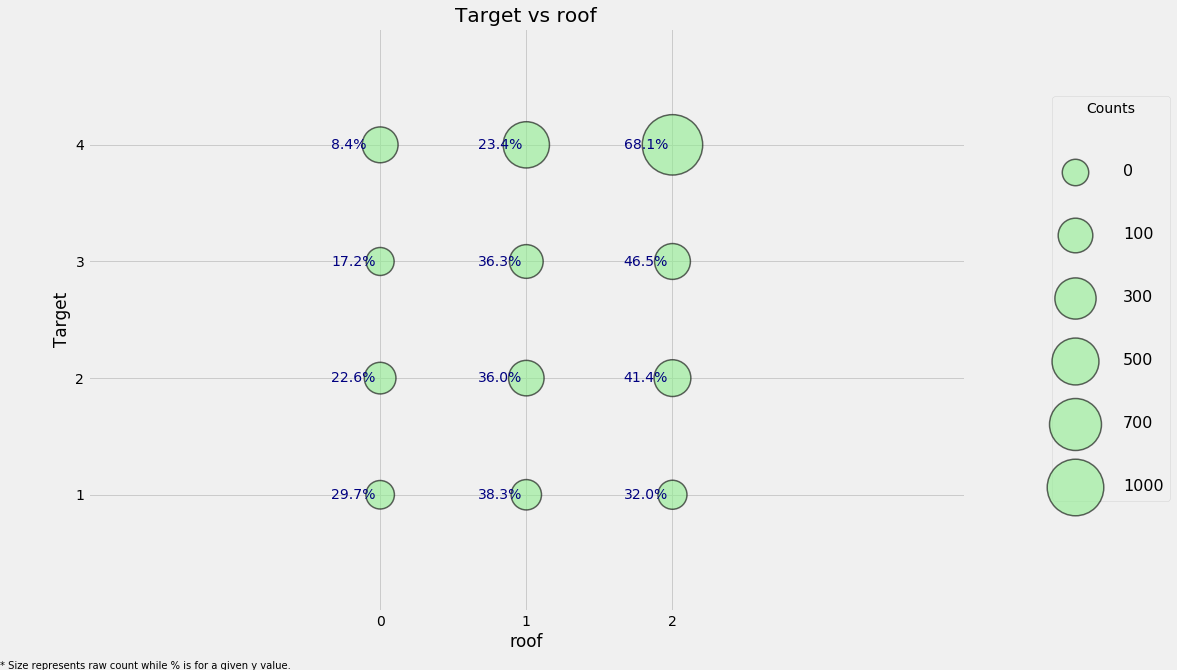

In [585]:
plot_categoricals('roof', 'Target', heads)

In [586]:
heads['floor'] = np.argmax(np.array(heads[['eviv1', 'eviv2', 'eviv3']]), axis=1)
heads = heads.drop(columns=['eviv1', 'eviv2', 'eviv3'])
heads['floor'].head()

0    0
1    1
2    2
5    2
8    1
Name: floor, dtype: int64

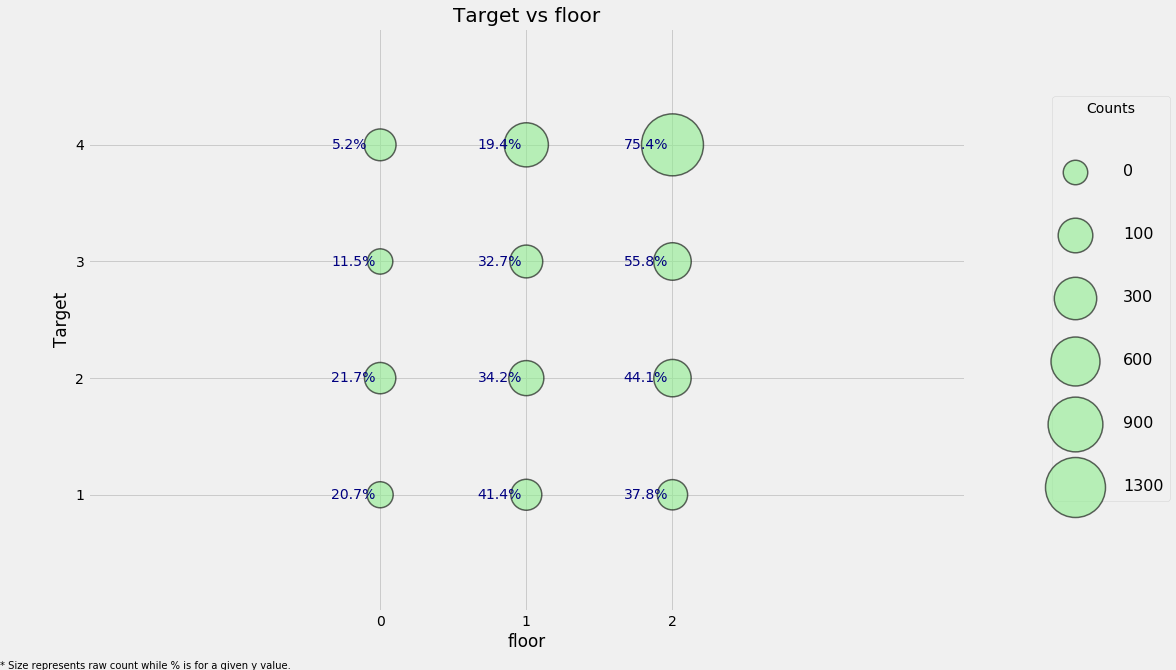

In [587]:
plot_categoricals('floor', 'Target', heads)

#### 3.5.4. Feature Construction
기존에 존재하는 데이터를 가지고 새로운 컬럼을 만들어 낼 수도 있습니다. 예를들면, 우리가 만들었던 세가지의 컬럼을 결합한 컬럼을 만들 수 있습니다.

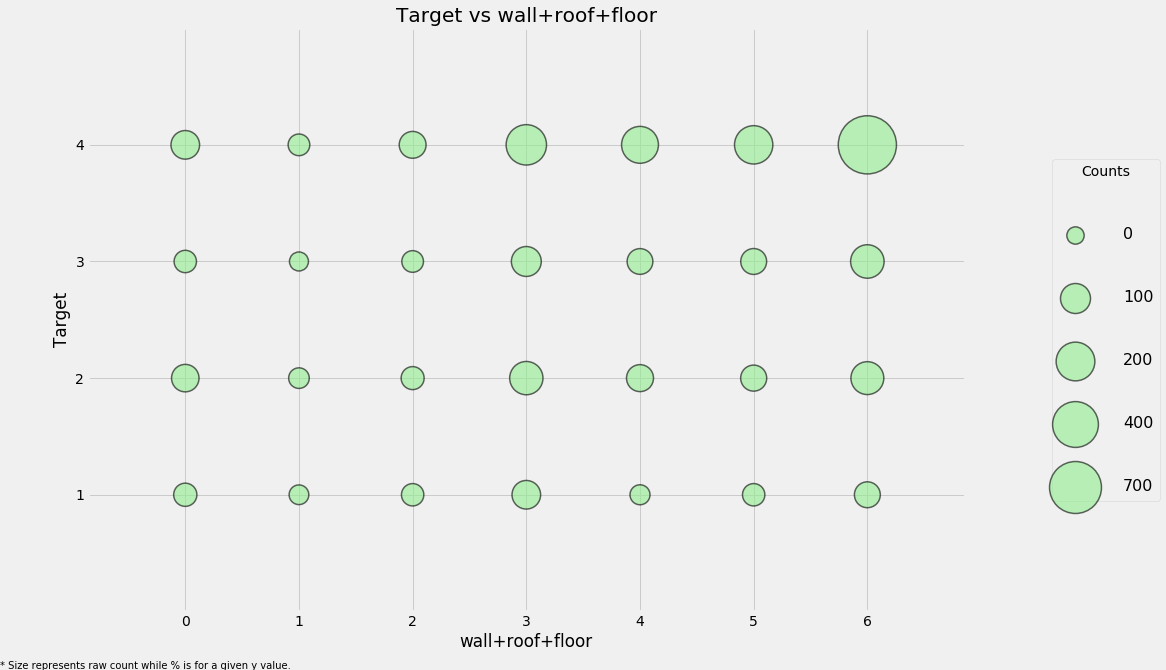

In [588]:
heads['wall+roof+floor'] = heads['wall'] + heads['roof'] + heads['floor']
plot_categoricals('wall+roof+floor', 'Target', heads, annotate=False)

이는 생각보다 유용합니다. 왜냐하면 타겟 라벨 4를 가진 값들이 대체로 집의 품질이 좋다고 판단할 수 있기 때문입니다.

세부적으로 보기위해 표로 만들어보자.

In [589]:
count = pd.DataFrame(heads.groupby('wall+roof+floor')['Target'].value_counts(
    normalize=True)).rename(columns={'Target': 'Nomarlized Count'}).reset_index()
count.head(10)

,wall+roof+floor,Target,Nomarlized Count
0,0,4.0,0.376404
1,0,2.0,0.320225
2,0,1.0,0.162921
3,0,3.0,0.140449
4,1,4.0,0.323529
5,1,2.0,0.264706
6,1,1.0,0.220588
7,1,3.0,0.191176
8,2,4.0,0.409449
9,2,2.0,0.220472


다음으로는 집의 위험도 정도를 나타내보자. 화장실, 전기, 바닥, 수도, 천장이 없는 경우 각각 -1점씩 감점이 될 것이다.

In [590]:
heads['warning'] = 1 * (heads['sanitario1'] + (heads['elec'] == 0) +
                        heads['pisonotiene'] + heads['abastaguano'] + (heads['cielorazo'] == 0))

우리는 앞서 정의한 `plot_categoricals` 함수를 사용하여 관계를 시각화할 수 있지만 seaborn에서도 카테고리형 변수를 가지고 할 수 있는 plotting option을 제공한다. 그 중 하나는 violinplot인데, y축에 변수의 분포를 나타내고 각 플롯의 너비는 해당 카테고리의 관측치 수(number of observations)를 보여준다.

Text(0.5, 1.0, 'target vs warning variable')

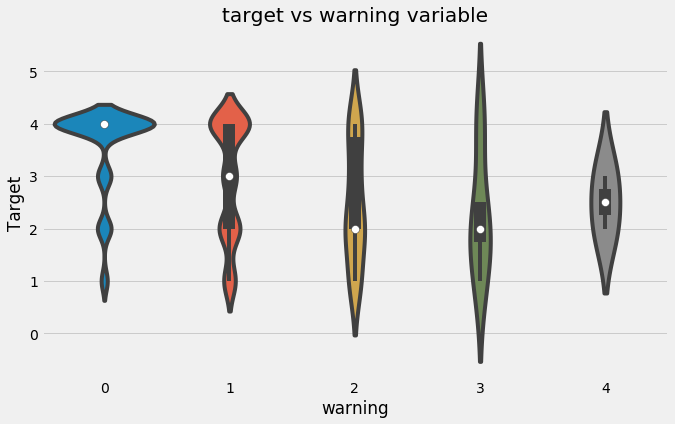

In [591]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='warning', y='Target', data=heads)
plt.title('target vs warning variable')

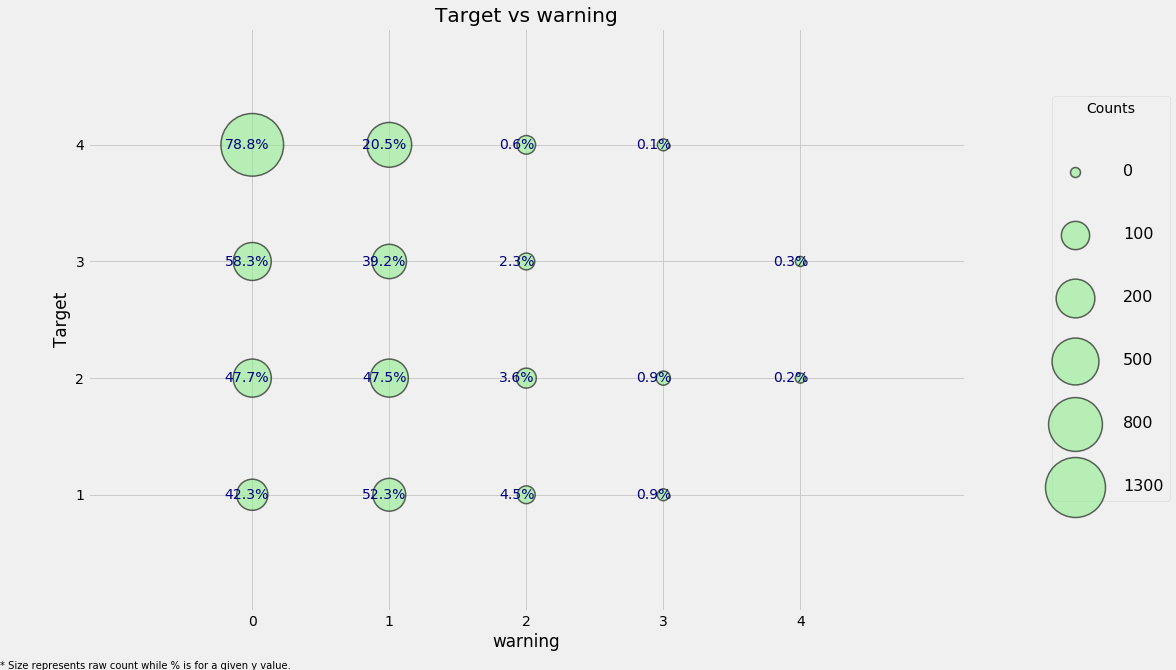

In [592]:
plot_categoricals('warning', 'Target', data=heads)

바이올린 플롯은 여기서는 그리 좋아보이지 않습니다. 왜냐하면 만약 타겟이 실제보다 작거나 크게 보이는데 이는 카테고리 변수가 영향을 받기 때문입니다. 그럼에도 불구하고 우리는 많은 가구들이 위험요소가 적으면 빈곤정도가 적다는 것을 알 수 있습니다. 유용한 것 처럼 보이지만, 모델링때 쓰여질 지는 모르겠습니다.

#### 3.5.5. Per Capita Features
우리가 만들 수 있는 추가적인 피처들은 가구의 각 개인의 특정 측정(?) 횟수를 계산할 수 있다.

Text(0.5, 1.0, 'target vs bonus variable')

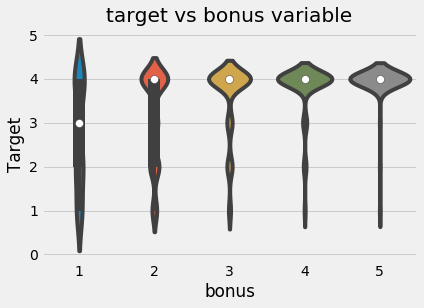

In [593]:
# 냉장고, 컴퓨터, 태블릿, TV 소유 여부
heads['bonus'] = 1 + (heads['refrig'] + heads['computer'] +
                      (heads['v18q1'] > 0) + heads['television'])
sns.violinplot('bonus', 'Target', data=heads, figsize=(10, 6))
plt.title('target vs bonus variable')

In [594]:
# 한 명당 가지고 있는 평균 개수를 말하는 듯
heads['phones-per-capita'] = heads['qmobilephone'] / heads['tamviv']
heads['tablets-per-capita'] = heads['v18q1'] / heads['tamviv']
heads['rooms-per-capita'] = heads['rooms'] / heads['tamviv']
heads['rent-per-capita'] = heads['v2a1'] / heads['tamviv']

### 3.6. Exploring Household Variables

순서를 가진 컬럼들의 문제들을 모두 해결 했으니 이제 타겟 라벨과의 관계를 살펴봅시다. 이미 조금했지만, 양적인 관계를 살펴봅시다. (통계적인 방식을 말하는 거라 추측 중)

#### 3.6.1. Measuring Relationships
관계를 측정하는 방법에는 여러방법이 있지만 우리는 그중 두가지만 채택합시다. 
* 피어슨 상관계수 : 일반적으로 사용되는 상관계수
* 스피어맨 상관계수 : 해당 지표가 점차적으로 증가 또는 감소하는 관계를 보여주는 지표

스피어맨 상관관계는 한 변수가 증가할 때 다른 변수도 증가하면, 관계가 선형적이지 않더라도 1이다. 반면, 피어슨 상관관계는 증가가 정확히 선형일 경우에만 해당된다. 다음의 예시가 잘 설명되어 있다.

In [595]:
from scipy.stats import spearmanr

def plot_corrs(x, y):
    spr = spearmanr(x, y).correlation
    pcr = np.corrcoef(x, y)[0, 1]
    
    data = pd.DataFrame({'x':x, 'y':y})
    plt.figure(figsize=(6, 4))
    sns.regplot('x', 'y', data=data, fit_reg=False)
    plt.title(f'spearman: {round(spr, 2)}; pearson: {round(pcr, 2)}')

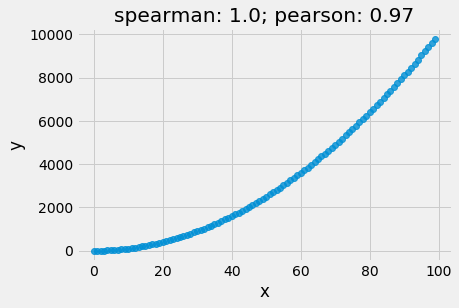

In [596]:
x = np.array(range(100))
y = x**2

plot_corrs(x, y)

Spearman 상관계수는 타겟이나 교육년수와 같은 순서적인 변수들에게 좋을 것이다. 실제로는 모든 관계가 선형일리는 없으며, 비록 Pearson 상관계수가 두 변수가 어떻게 관계있는지에 대한 대략적인 것을 보여 줄지라도 비교에 있어서 항상 최고의 방법은 아니다.

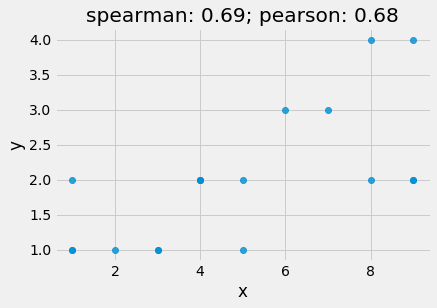

In [597]:
x = np.array([1, 1, 1, 2, 3, 3, 4, 4, 4, 5, 5, 6, 7, 8, 8, 9, 9, 9])
y = np.array([1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 3, 3, 2, 4, 2, 2, 4])
plot_corrs(x, y)

대부분의 경우 값이 비슷하다.

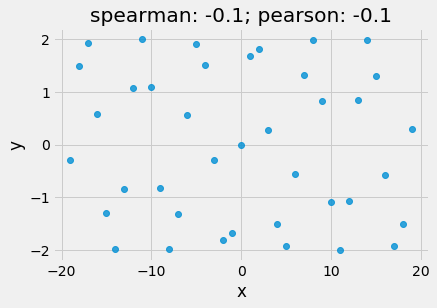

In [598]:
x = np.array(range(-19, 20))
y = 2 * np.sin(x)
plot_corrs(x, y)

먼저 Target과 모든 변수 사이의 피어슨 상관관계를 계산해보자.

In [599]:
train_heads = heads.loc[heads['Target'].notnull(), :].copy()

pcorrs = pd.DataFrame(train_heads.corr()['Target'].sort_values()).rename(columns={'Target':'pcorr'}).reset_index()
pcorrs = pcorrs.rename(columns={'index': 'feature'})

print('음의 상관관계를 가진 변수들 TOP 5')
print(pcorrs.head())

print('\n양의 상관관계를 가진 변수들 TOP 5')
print(pcorrs.dropna().tail())

음의 상관관계를 가진 변수들 TOP 5
        feature     pcorr
0       warning -0.301791
1     hogar_nin -0.266309
2          r4t1 -0.260917
3  overcrowding -0.234954
4          r4m1 -0.209479

양의 상관관계를 가진 변수들 TOP 5
              feature     pcorr
87  phones-per-capita  0.299026
88              floor  0.307605
89    wall+roof+floor  0.332446
90           meaneduc  0.333652
91             Target  1.000000


음의 상관관계는 임의의 해당 상관관게의 값이 증가하면 타겟라벨은 감소할 것입니다(이는 더 빈곤하다는 것을 의미함 )그러므로 warning이 증가하면 부의 타겟 라벨은 더 빈곤하다는 것을 의미할 것입니다. hogar_nin은 0-19세의 아이들의 수인데 이 또한 말이 맞는듯합니다: 어린 아이들은 경제적인 지원이 많이 필요하기 때문에 가족의 부의 수준을 떨어뜨릴 것입니다. 또는 사회경제적 지위가 낮은 가정은 그들 중 한 명이 성공하기를 바라는 마음에 더 많은 자식을 갖기도 한다. 이유에 어떻든 간에 가족의 크기와 빈곤 정도는 어느 정도 연관성을 보인다 볼 수 있다.
반면 양의 관계에서는, 위의 음의 관계와 반대로 생각하시면 됩니다. 가장 높은 수치는 meaneduc이며, 이는 가정의 어른들의 평균 교육 단게를 의미합니다. 교육 수준과 부의 단계는 또한 말이 맞는 것 같습니다. 어느것이 타겟라벨을 움직이는지 면밀히 파악할 필요는 없지만, 양의 방향으로 같이 관계를 가진다는 정도로 알아둘 필요가 있습니다.

아래는 상관관계를 해석하는 수치별 정도입니다. (저번 노트북에 있던 걸 참고)

자 이제 스피어맨 상관계수로 넘어가보자.

In [600]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

feats = []
scorr = []
pvalues = []

for c in heads:
    if heads[c].dtype != 'object':
        feats.append(c)
        
        scorr.append(spearmanr(train_heads[c], train_heads['Target']).correlation)
        pvalues.append(spearmanr(train_heads[c], train_heads['Target']).pvalue)
        
scorrs = pd.DataFrame({'feature': feats, 'scorr': scorr, 'pvalue': pvalues}).sort_values('scorr')

spearman 상관계수는 관계의 유의수준을 결정하는 pvalue와 함께 계산합니다. 다중 비교를 하더라도 임의의 pvalue가 0.05보다 작은 경우 우리는 유의하다고 판단합니다. 그래서 비교 횟수별로 p-value를 나눕니다. 이 과정을 베루누이 상관관계라고 합니다.

In [601]:
print('음의 스피어맨 상관계수 TOP 5:')
print(scorrs.head())
print('\n양의 스피어맨 상관계수 TOP 5:')
print(scorrs.dropna().tail())

음의 스피어맨 상관계수 TOP 5:
        feature     scorr        pvalue
87      warning -0.307326  4.682829e-66
58   dependency -0.281516  2.792620e-55
75    hogar_nin -0.236225  5.567218e-39
70         r4t1 -0.219226  1.112230e-33
8   pisocemento -0.209387  8.270816e-31

양의 스피어맨 상관계수 TOP 5:
              feature     scorr        pvalue
23          cielorazo  0.300996  2.611808e-63
85              floor  0.309638  4.466091e-67
89  phones-per-capita  0.337377  4.760104e-80
86    wall+roof+floor  0.338791  9.539346e-81
0              Target  1.000000  0.000000e+00


대부분의 경우 상관계수를 계산하는 두 방법은 거의 일치한다. 단지 호기심에서 두 상관계수의 값이 많이 차이나는 값들을 찾아보자.

In [602]:
corrs = pcorrs.merge(scorrs, on='feature')
corrs['diff'] = corrs['pcorr'] - corrs['scorr']

corrs.sort_values('diff').head()

,feature,pcorr,scorr,pvalue,diff
69,rooms-per-capita,0.152185,0.223303,6.521453e-35,-0.071119
77,v18q1,0.197493,0.244200,1.282664e-41,-0.046708
79,tablets-per-capita,0.204638,0.248642,3.951568e-43,-0.044004
2,r4t1,-0.260917,-0.219226,1.112230e-33,-0.041691
87,phones-per-capita,0.299026,0.337377,4.760104e-80,-0.038351


In [603]:
corrs.sort_values('diff').dropna().tail()

,feature,pcorr,scorr,pvalue,diff
50,techozinc,0.014357,0.003404,8.528369e-01,0.010954
44,hogar_mayor,-0.025173,-0.041722,2.290994e-02,0.016549
80,edjefe,0.235687,0.214736,2.367521e-32,0.020951
58,edjefa,0.052310,0.005114,7.804715e-01,0.047197
13,dependency,-0.126465,-0.281516,2.792620e-55,0.155051


두 상관계수 간의 가장 큰 불일치는 `dependency`이다. 우리는 Target과 `dependency` 사이의 관계를 시각화하기 위해 scatterplot을 만들어보자. 이 두 변수 모두 이산형 변수들이기 때문에 그림에 jitter를 조금 추가할 것이다.

Text(0.5, 1, 'target vs dependency')

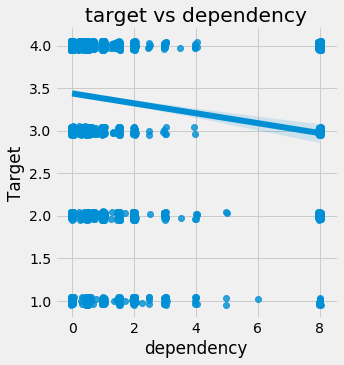

In [604]:
sns.lmplot('dependency', 'Target', fit_reg=True, data=train_heads, x_jitter=0.05, y_jitter=0.05)
plt.title('target vs dependency')

상관관계를 보긴 어렵지만 약간의 음의 상관관게를 가짐을 의미합니다. 이는 dependency가 (부양해야할 가족 / 부양하는 가족)을 의미하기 때문에 이를 유추할수 있습니다. 이 값이 증가할수록 빈곤 정도가 심각해지는 경향이 있다: 더 많은 부양해야할 가족(일을 하지 않는)이 있을수록 그들이 독립적인, 의존하지 않는 가족 구성원에 의해 부양되어야 하기 때문에 더 높은 수준의 빈곤으로 이어진다.

Text(0.5, 1, 'target vs rooms-per-capita')

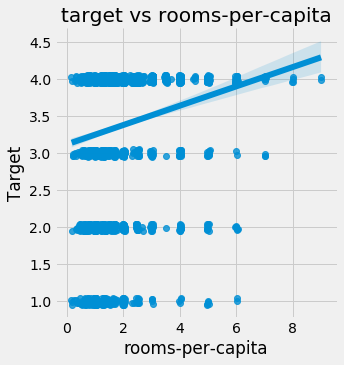

In [605]:
sns.lmplot('rooms-per-capita', 'Target', fit_reg=True, data=train_heads, x_jitter=0.05, y_jitter=0.05)
plt.title('target vs rooms-per-capita')

#### 3.6.2. Correlation Heatmap
저자가 가장 좋아하는 plot은 heatmap인데, 이는 하나의 이미지에 많은 정보를 보여주기 때문이다. heatmap을 그리기 위해, 7개의 변수를 선택하여 변수 간의 상관관계를 보여줄 것이다

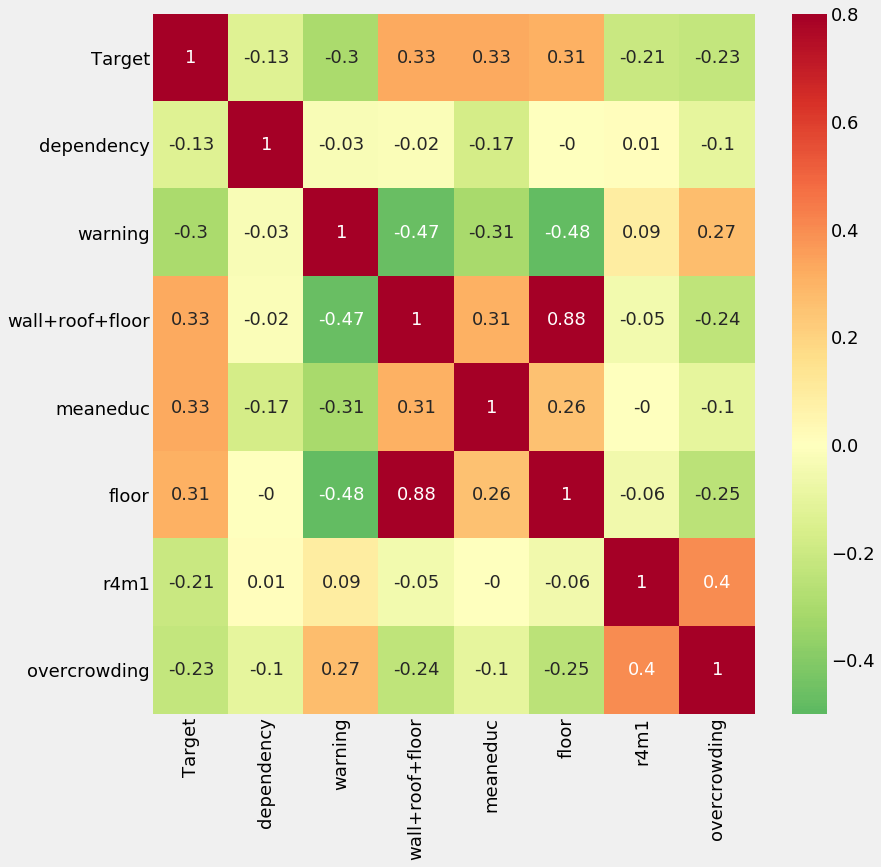

In [606]:
variables = ['Target', 'dependency', 'warning', 'wall+roof+floor',
             'meaneduc', 'floor', 'r4m1', 'overcrowding']

corr_mat = train_heads[variables].corr().round(2)
plt.rcParams['font.size'] = 18
plt.figure(figsize=(12, 12))
sns.heatmap(corr_mat, vmin=-0.5, vmax=0.8, center=0,
            cmap=plt.cm.RdYlGn_r, annot=True)

이 그래프는 Target과 약한 상관관계를 가지는 변수들이 많음을 보여준다. 몇몇 변수들과 높은 상관관계를 보이는데(ex. walls+roof+floor, floor) 이는 공선성(colinearlity)으로 인해 문제가 될 수 있다.

#### 3.6.3. Features Plot
가계 수준 데이터의 최종 탐구를 위해, 우리는 target과 가장 상관관계가 큰 변수들 중 몇 가지를 그래프로 그려볼 것이다. 이는 위쪽 삼각형을 scatterplot, 대각선을 kdeplot, 아래쪽 삼각형을 2d kdeplot으로 하여 보여준다.

Text(0.5, 1.05, 'feature plots covered by target')

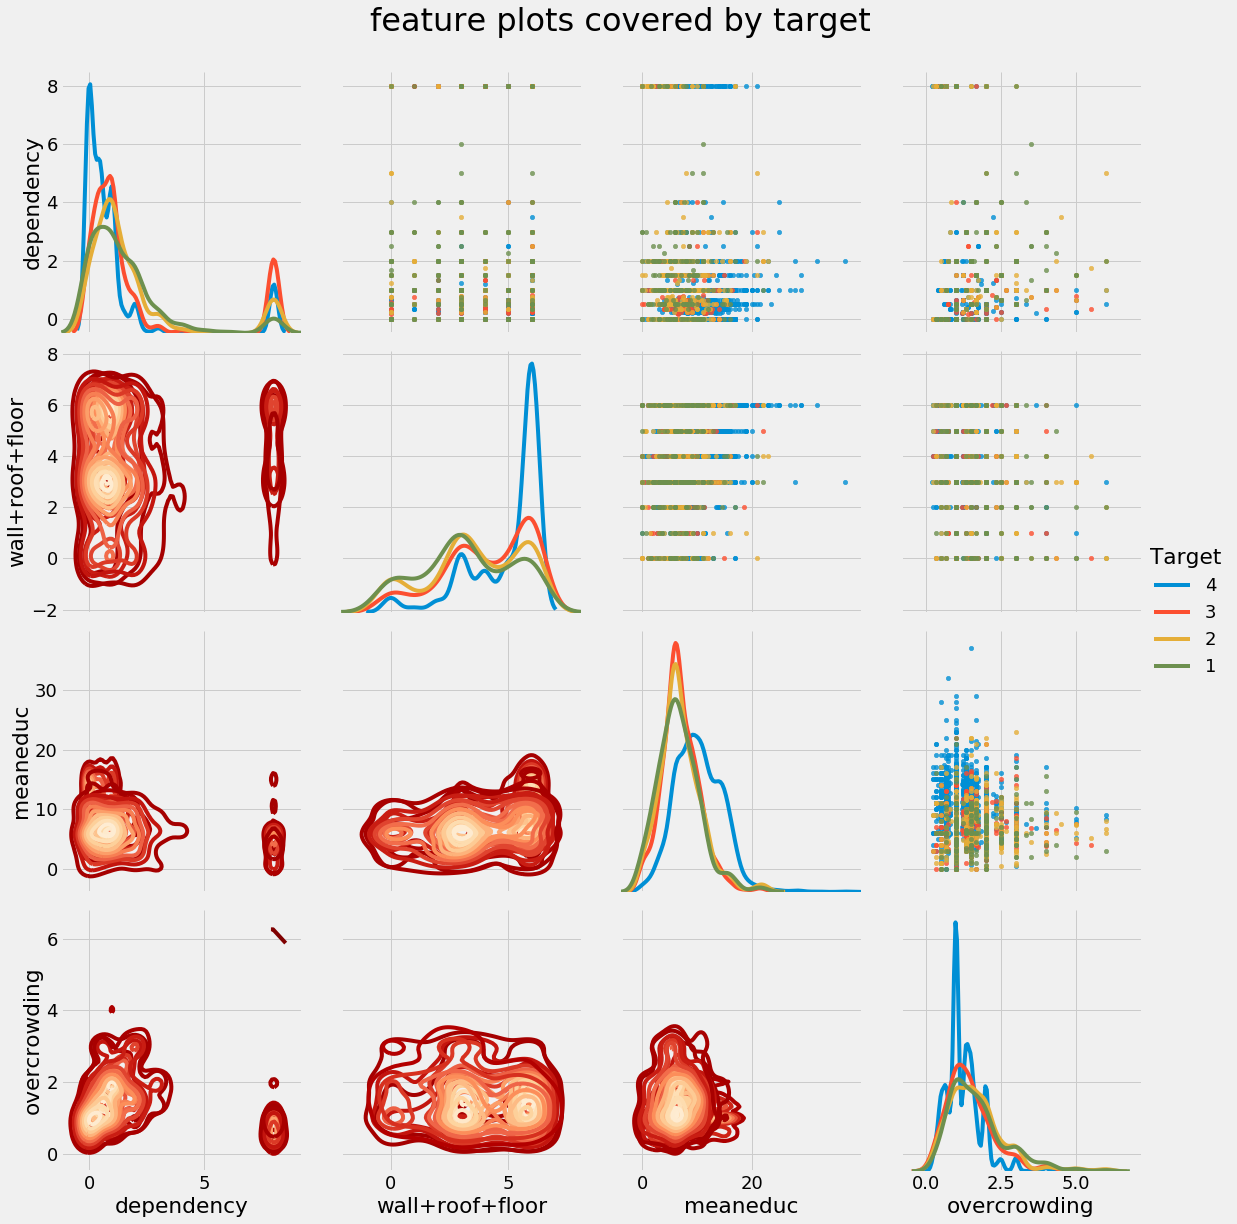

In [607]:
import warnings
warnings.filterwarnings('ignore')

plot_data = train_heads[['Target', 'dependency', 'wall+roof+floor', 'meaneduc', 'overcrowding']]

# pairgrid 객체 생성
grid = sns.PairGrid(data=plot_data, size=4, diag_sharey=False,
                   hue='Target', hue_order=[4, 3, 2, 1],
                   vars=[x for x in list(plot_data.columns) if x != 'Target'])

# 위쪽 삼각형 - scatterplot
grid.map_upper(plt.scatter, alpha=0.8, s=20)

# 대각선 - kdeplot
grid.map_diag(sns.kdeplot)

# 아래쪽 삼각형 - 2d kdeplot
grid.map_lower(sns.kdeplot, cmap=plt.cm.OrRd_r)

grid = grid.add_legend()
plt.suptitle('feature plots covered by target', size=32, y=1.05)

이제 eda는 끝나고 특성공학 파트만을 남겨두고 있다. 나중에 모델의 성능이 마음에 들지 않는다면  다시 이 단계로 돌아올 것이다.

In [608]:
household_feats = list(heads.columns)

### 3.7. Individual Level Variables
개인 수준의 변수는 2가지 종류가 있다:
* 불리언 (1 or 0)
* 순서형 (순서를 가진 이산적인 값)

In [609]:
ind = data[id_ + ind_bool + ind_ordered]
ind.shape

(33413, 40)

#### 3.7.1. Redundant Individual Variables
가계 수준 변수와 동일한 과정으로 중복된 개인 수준의 변수를 식별해낼 수 있다. 상관 계수의 절대 크기가 0.95보다 큰 변수에 초점을 맞춰보자.


In [610]:
corr_matrix = ind.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
to_drop = [col for col in upper.columns if any(abs(upper[col]) > 0.95)]
to_drop

['female']

이 변수는 `male`의 반대이다. `male` 변수를 지워주자.

In [611]:
ind = ind.drop(columns='male')

#### 3.7.2. Creating Ordinal Variables
가구단위에서 했듯이 논리형 컬럼들을 결합하여 하나의 순서형 컬럼을 만들 수 있습니다. instlevel 변수들은 개개인의 교육의 정도를 나타내는데 1부터 9까지 존재합니다. 순서형 변수를 만들기 위해 각 개별 변수들에 0이 아닌 컬럼들을 찾기만 하면 됩니다. 교육수준은 높은 순서가 더 좋은 교육수준을 나타내도록 합시다.

In [612]:
ind[[col for col in ind.columns if col.startswith('instlevel')]].head()

,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9
0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0


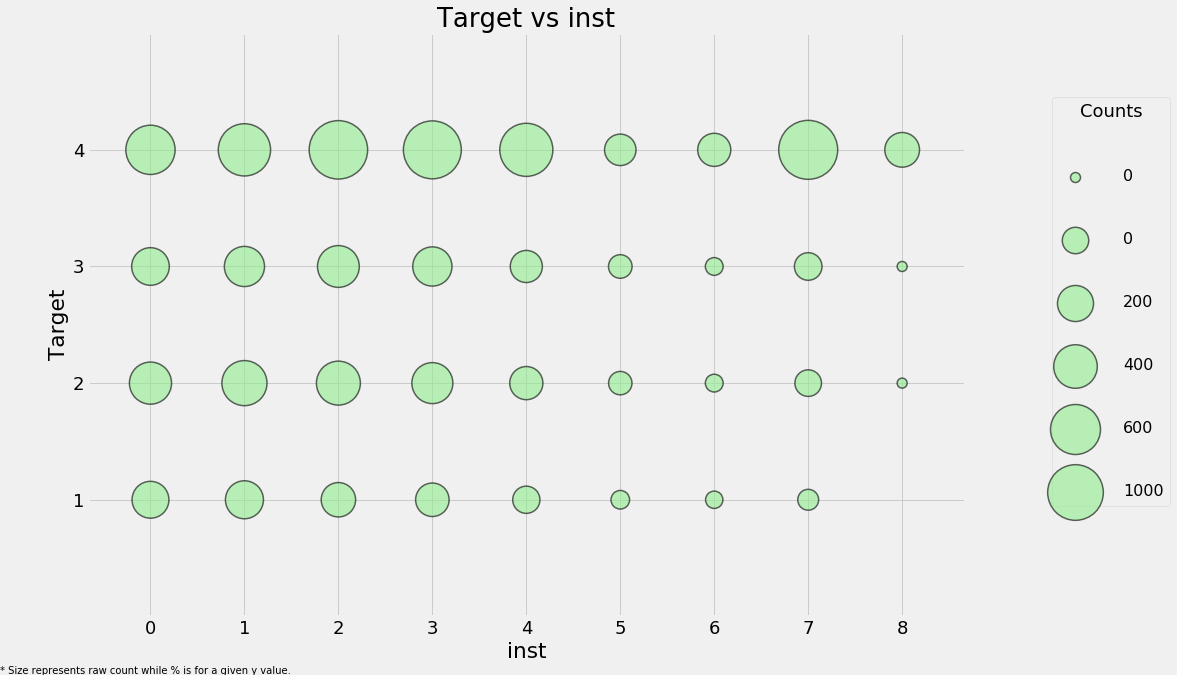

In [613]:
ind['inst'] = np.argmax(np.array(
    ind[[col for col in ind.columns if col.startswith('instlevel')]]), axis=1)
plot_categoricals('inst', 'Target', ind, annotate=False)

높은 교육수준은 타겟라벨이 높은 수준으로 상관관계를 가지며 우리는 개별적인 컬럼을 전체 가구수준의 컬럼으로 합치려는 작업을 해야 한다는 것을 명심해야한다.

Text(0.5, 1.0, 'education distribution by target')

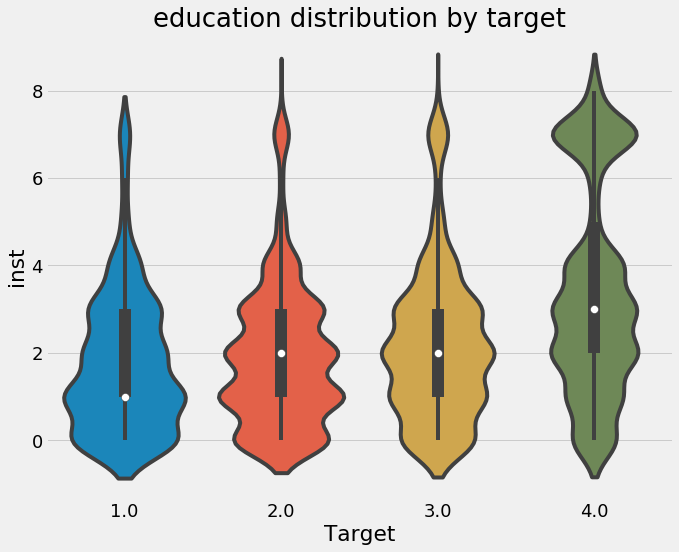

In [614]:
plt.figure(figsize=(10, 8))
sns.violinplot(x='Target', y='inst', data=ind)
plt.title('education distribution by target')

In [615]:
# education 피처 제거
ind = ind.drop(columns=[c for c in ind if c.startswith('instlevel')])
ind.shape

(33413, 31)

#### 3.7.3. Feature Construction
존재하는 데이터를 이용해서 몇개의 컬럼들을 만들어 봅시다. 예를 들어, 나이를 기준으로 학교 재학기간을 나눌 수 있다.

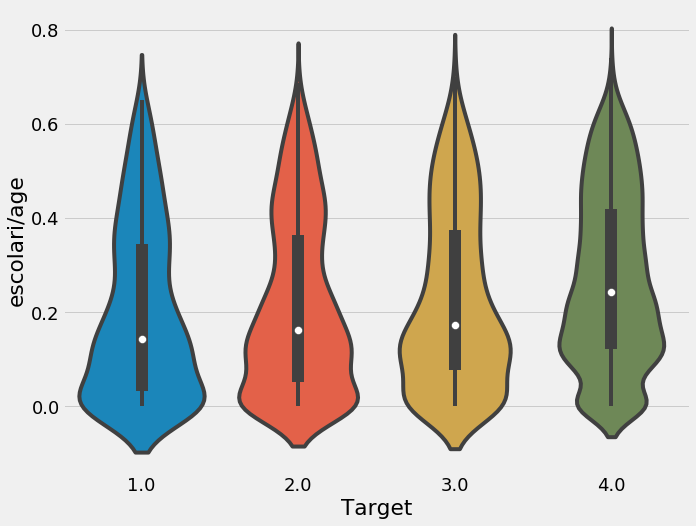

In [616]:
ind['escolari/age'] = ind['escolari'] / ind['age']
plt.figure(figsize=(10, 8))
sns.violinplot('Target', 'escolari/age', data=ind)

또한 우리는 inst를 age로 나누어 새로운 피처를 만들 수 있다. 우리가 이름을 붙일 마지막 피처 `tech`는 tablet과 핸드폰 개수의 합을 나타낸다.

In [617]:
ind['inst/age'] = ind['inst'] / ind['age']
ind['tech'] = ind['v18q'] + ind['mobilephone']
ind['tech'].describe()

count    33413.000000
mean         1.214886
std          0.462567
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: tech, dtype: float64

### 3.8. Feature Engineering through Aggregations
개별 데이터를 가구별 데이터로 변환하기 위해서 각각의 가구별로 병합을 할 필요가 있습니다. 가장 간단한 방법으로는 가구별 식별자로 그룹후에 그룹함수를 사용하는 것입니다. 순서 및 연속적인 변수에 대해서 그룹함수를 사용하는데 있어서 여섯가지가 있으며, 한가지는 직접 정의해서 사용할 것입니다. 논리형 변수도 결합하는 것이 같지만, 이는 우리가 나중에 버릴 수도 있는 중복된 컬럼들이 생기는 경우가 될 수 있습니다. 우리는 같은 결합정책을 사용하고 나중에 돌아가서 중복되는 컬럼들을 제거 할 것입니다.

In [618]:
def range_(x): return x.max() - x.min()


range_.__name__ = 'range_'

ind_agg = ind.drop(columns='Target').groupby('idhogar').agg(
    ['min', 'max', 'sum', 'count', 'std', range_])
ind_agg.head()

v18q                           dis                                 \
           min max sum count  std range_ min max sum count       std range_   
idhogar                                                                       
000a08204    1   1   3     3  0.0      0   0   0   0     3  0.000000      0   
000bce7c4    0   0   0     2  0.0      0   0   1   1     2  0.707107      1   
001845fb0    0   0   0     4  0.0      0   0   0   0     4  0.000000      0   
001ff74ca    1   1   2     2  0.0      0   0   0   0     2  0.000000      0   
003123ec2    0   0   0     4  0.0      0   0   0   0     4  0.000000      0   

          female                                estadocivil1                \
             min max sum count       std range_          min max sum count   
idhogar                                                                      
000a08204      0   1   1     3  0.577350      1            0   1   1     3   
000bce7c4      0   1   1     2  0.707107      1            0   0   0     2   
001845fb0      0   1   2     4  0.577350      1            0   0   0     4   
001ff74ca      1   1   2     2  0.000000      0            0   1   1     2   
003123ec2      0   1   1     4  0.500000      1            0   1   2     4   

                           estadocivil2                                \
                std range_          min max sum count      std range_   
idhogar                                                                 
000a08204  0.577350      1            0   1   2     3  0.57735      1   
000bce7c4  0.000000      0            0   0   0     2  0.00000      0   
001845fb0  0.000000      0            0   1   2     4  0.57735      1   
001ff74ca  0.707107      1            0   0   0     2  0.00000      0   
003123ec2  0.577350      1            0   1   2     4  0.57735      1   

          estadocivil3                           estadocivil4                \
                   min max sum count  std range_          min max sum count   
idhogar                                                                       
000a08204            0   0   0     3  0.0      0            0   0   0     3   
000bce7c4            1   1   2     2  0.0      0            0   0   0     2   
001845fb0            0   0   0     4  0.0      0            0   0   0     4   
001ff74ca            0   0   0     2  0.0      0            0   0   0     2   
003123ec2            0   0   0     4  0.0      0            0   0   0     4   

                      estadocivil5                                 \
           std range_          min max sum count       std range_   
idhogar                                                             
000a08204  0.0      0            0   0   0     3  0.000000      0   
000bce7c4  0.0      0            0   0   0     2  0.000000      0   
001845fb0  0.0      0            0   0   0     4  0.000000      0   
001ff74ca  0.0      0            0   1   1     2  0.707107      1   
003123ec2  0.0      0            0   0   0     4  0.000000      0   

          estadocivil6                           estadocivil7                \
                   min max sum count  std range_          min max sum count   
idhogar                                                                       
000a08204            0   0   0     3  0.0      0            0   0   0     3   
000bce7c4            0   0   0     2  0.0      0            0   0   0     2   
001845fb0            0   0   0     4  0.0      0            0   1   2     4   
001ff74ca            0   0   0     2  0.0      0            0   0   0     2   
003123ec2            0   0   0     4  0.0      0            0   0   0     4   

                          parentesco1                                 \
               std range_         min max sum count       std range_   
idhogar                                                                
000a08204  0.00000      0           0   1   1     3  0.577350      1   
000bce7c4  0.00000      0           0   1   1     2  0.70710

In [619]:
new_cols = []

for col in ind_agg.columns.levels[0]:
    for stat in ind_agg.columns.levels[1]:
        new_cols.append(f'{col}-{stat}')

ind_agg.columns = new_cols
ind_agg.head()

,v18q-min,v18q-max,v18q-sum,v18q-count,v18q-std,v18q-range_,dis-min,dis-max,dis-sum,dis-count,dis-std,dis-range_,female-min,female-max,female-sum,female-count,female-std,female-range_,estadocivil1-min,estadocivil1-max,estadocivil1-sum,estadocivil1-count,estadocivil1-std,estadocivil1-range_,estadocivil2-min,estadocivil2-max,estadocivil2-sum,estadocivil2-count,estadocivil2-std,estadocivil2-range_,estadocivil3-min,estadocivil3-max,estadocivil3-sum,estadocivil3-count,estadocivil3-std,estadocivil3-range_,estadocivil4-min,estadocivil4-max,estadocivil4-sum,estadocivil4-count,estadocivil4-std,estadocivil4-range_,estadocivil5-min,estadocivil5-max,estadocivil5-sum,estadocivil5-count,estadocivil5-std,estadocivil5-range_,estadocivil6-min,estadocivil6-max,estadocivil6-sum,estadocivil6-count,estadocivil6-std,estadocivil6-range_,estadocivil7-min,estadocivil7-max,estadocivil7-sum,estadocivil7-count,estadocivil7-std,estadocivil7-range_,parentesco1-min,parentesco1-max,parentesco1-sum,parentesco1-count,parentesco1-std,parentesco1-range_,parentesco2-min,parentesco2-max,parentesco2-sum,parentesco2-count,parentesco2-std,parentesco2-range_,parentesco3-min,parentesco3-max,parentesco3-sum,...,parentesco8-count,parentesco8-std,parentesco8-range_,parentesco9-min,parentesco9-max,parentesco9-sum,parentesco9-count,parentesco9-std,parentesco9-range_,parentesco10-min,parentesco10-max,parentesco10-sum,parentesco10-count,parentesco10-std,parentesco10-range_,parentesco11-min,parentesco11-max,parentesco11-sum,parentesco11-count,parentesco11-std,parentesco11-range_,parentesco12-min,parentesco12-max,parentesco12-sum,parentesco12-count,parentesco12-std,parentesco12-range_,mobilephone-min,mobilephone-max,mobilephone-sum,mobilephone-count,mobilephone-std,mobilephone-range_,rez_esc-min,rez_esc-max,rez_esc-sum,rez_esc-count,rez_esc-std,rez_esc-range_,escolari-min,escolari-max,escolari-sum,escolari-count,escolari-std,escolari-range_,age-min,age-max,age-sum,age-count,age-std,age-range_,inst-min,inst-max,inst-sum,inst-count,inst-std,inst-range_,escolari/age-min,escolari/age-max,escolari/age-sum,escolari/age-count,escolari/age-std,escolari/age-range_,inst/age-min,inst/age-max,inst/age-sum,inst/age-count,inst/age-std,inst/age-range_,tech-min,tech-max,tech-sum,tech-count,tech-std,tech-range_
idhogar,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000a08204,1,1,3,3,0.0,0,0,0,0,3,0.000000,0,0,1,1,3,0.577350,1,0,1,1,3,0.577350,1,0,1,2,3,0.57735,1,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.000000,0,0,0,0,3,0.0,0,0,0,0,3,0.00000,0,0,1,1,3,0.577350,1,0,1,1,3,0.577350,1,0,1,1,...,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.0,0,1,1,3,3,0.0,0,0.0,0.0,0.0,3,0.0,0.0,0,14,26,3,7.571878,14,4,30,62,3,14.468356,26,0,7,14,3,4.041452,7,0.000000,0.500000,0.900000,3,0.264575,0.500000,0.000000,0.250000,0.483333,3,0.139775,0.250000,2,2,6,3,0.0,0
000bce7c4,0,0,0,2,0.0,0,0,1,1,2,0.707107,1,0,1,1,2,0.707107,1,0,0,0,2,0.000000,0,0,0,0,2,0.00000,0,1,1,2,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.000000,0,0,0,0,2,0.0,0,0,0,0,2,0.00000,0,0,1,1,2,0.707107,1,0,1,1,2,0.707107,1,0,0,0,...,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,1,1,2,2,0.0,0,0.0,0.0,0.0,2,0.0,0.0,0,5,5,2,3.535534,5,60,63,123,2,2.121320,3,0,1,1,2,0.707107,1,0.000000,0.083333,0.083333,2,0.058926,0.083333,0.000000,0.016667,0.016667,2,0.011785,0.016667,1,1,2,2,0.0,0
001845fb0,0,0,0,4,0.0,0,0,0,0,4,0.000000,0,0,1,2,4,0.577350,1,0,0,0,4,0.000000,0,0,1,2,4,0.57735,1,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.000000,0,0,0,0,4,0.0,0,0,1,2,4,0.57735,1,0,1,1,4,0.500000,1,0,1,1,4,0.500000,1,0,1,2,...,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,1,1,4,4,0.0,0,0.0,0.0,0.0,3,0.0,0.0,6,14,41,4,3.304038,8,19,52,142,4,16.421531,33,2,7,16,4,2.160247,5,0.115385,0.526316,1.397906,4,0.183106,0.410931,0.038462,0.166667,0.511959,4,0.060123,0.128205,1,1,4,4,0.0,0
001ff74ca,1,1,2,2,0.0,0,0,0,0,2,0.000000,0,1,1,2,2,0.000000,0,0

In [620]:
ind_agg.shape

(10340, 180)

#### 3.8.1. Feature Selection
특성 선택의 첫 번째 라운드로서, 0.95보다 큰 상관관계를 가진 변수 쌍 중 하나를 제거할 수 있다.

In [621]:
corr_matrix = ind_agg.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [col for col in upper.columns if any(abs(upper[col]) > 0.95)]

print(f'총 {len(to_drop)}개의 제거할, 상관관계가 있는 변수들이 존재합니다.')

총 85개의 제거할, 상관관계가 있는 변수들이 존재합니다.


In [622]:
to_drop

['v18q-max',
 'dis-count',
 'dis-std',
 'dis-range_',
 'female-count',
 'estadocivil1-count',
 'estadocivil1-std',
 'estadocivil1-range_',
 'estadocivil2-sum',
 'estadocivil2-count',
 'estadocivil2-range_',
 'estadocivil3-sum',
 'estadocivil3-count',
 'estadocivil3-range_',
 'estadocivil4-sum',
 'estadocivil4-count',
 'estadocivil4-std',
 'estadocivil4-range_',
 'estadocivil5-count',
 'estadocivil5-std',
 'estadocivil5-range_',
 'estadocivil6-sum',
 'estadocivil6-count',
 'estadocivil6-std',
 'estadocivil6-range_',
 'estadocivil7-count',
 'estadocivil7-range_',
 'parentesco1-sum',
 'parentesco1-count',
 'parentesco1-range_',
 'parentesco2-sum',
 'parentesco2-count',
 'parentesco2-range_',
 'parentesco3-count',
 'parentesco3-std',
 'parentesco3-range_',
 'parentesco4-count',
 'parentesco4-std',
 'parentesco4-range_',
 'parentesco5-sum',
 'parentesco5-count',
 'parentesco5-std',
 'parentesco5-range_',
 'parentesco6-count',
 'parentesco6-std',
 'parentesco6-range_',
 'parentesco7-sum',
 '

우리는 이 컬럼들을 제거하고 heads 데이터끼리 병합하여 최종 데이터프레임을 생성한다.

In [623]:
ind_agg = ind_agg.drop(columns=to_drop)
ind_feats = list(ind_agg.columns)

final = heads.merge(ind_agg, on='idhogar', how='left')
print('final features shape', final.shape)

final features shape (10307, 190)


In [624]:
final.head()

,Id,idhogar,Target,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,v2a1-missing,v2a1,dependency,edjefe,edjefa,meaneduc,overcrowding,rooms,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,v18q1,...,estadocivil3-max,estadocivil3-std,estadocivil4-min,estadocivil4-max,estadocivil5-min,estadocivil5-max,estadocivil5-sum,estadocivil6-min,estadocivil6-max,estadocivil7-min,estadocivil7-max,estadocivil7-sum,estadocivil7-std,parentesco1-min,parentesco1-max,parentesco1-std,parentesco2-min,parentesco2-max,parentesco2-std,parentesco3-min,parentesco3-max,parentesco3-sum,parentesco4-min,parentesco4-max,parentesco4-sum,parentesco5-min,parentesco5-max,parentesco6-min,parentesco6-max,parentesco6-sum,parentesco7-min,parentesco7-max,parentesco8-min,parentesco8-max,parentesco9-min,parentesco9-max,parentesco9-sum,parentesco10-min,parentesco10-max,parentesco11-min,parentesco11-max,parentesco11-sum,parentesco12-min,parentesco12-max,parentesco12-sum,mobilephone-min,mobilephone-std,mobilephone-range_,rez_esc-min,rez_esc-max,escolari-min,escolari-max,escolari-sum,escolari-std,escolari-range_,age-min,age-max,age-sum,age-std,age-range_,inst-max,inst-std,inst-range_,escolari/age-min,escolari/age-max,escolari/age-sum,escolari/age-std,escolari/age-range_,inst/age-max,inst/age-std,inst/age-range_,tech-min,tech-sum,tech-std,tech-range_
0,ID_279628684,21eb7fcc1,4.0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,190000.0,0.0,10.0,0.0,10.0,1.000000,3,0,1,1,0,0,0,0,1,0.0,...,0,NaN,1,1,0,0,0,0,0,0,0,0,NaN,1,1,NaN,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,0,0.0,0.0,10,10,10,NaN,0,43,43,43,NaN,0,3,NaN,0,0.232558,0.232558,0.232558,NaN,0.000000,0.069767,NaN,0.000000,1,1,NaN,0
1,ID_f29eb3ddd,0e5d7a658,4.0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,135000.0,8.0,12.0,0.0,12.0,1.000000,4,0,1,1,0,0,0,0,1,1.0,...,0,NaN,1,1,0,0,0,0,0,0,0,0,NaN,1,1,NaN,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,0,0.0,0.0,12,12,12,NaN,0,67,67,67,NaN,0,7,NaN,0,0.179104,0.179104,0.179104,NaN,0.000000,0.104478,NaN,0.000000,2,2,NaN,0
2,ID_68de51c94,2c7317ea8,4.0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,False,0.0,8.0,0.0,11.0,11.0,0.500000,8,0,0,0,0,1,1,0,1,0.0,...,0,NaN,0,0,0,0,0,1,1,0,0,0,NaN,1,1,NaN,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0.0,0.0,11,11,11,NaN,0,92,92,92,NaN,0,4,NaN,0,0.119565,0.119565,0.119565,NaN,0.000000,0.043478,NaN,0.000000,0,0,NaN,0
3,ID_ec05b1a7b,2b58d945f,4.0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,180000.0,1.0,11.0,0.0,11.0,1.333333,5,0,2,2,1,1,2,1,3,1.0,...,0,0.0,0,0,0,0,0,0,0,0,1,1,0.5,0,1,0.5,0,1,0.5,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0,0.0,1.0,2,11,33,4.272002,9,8,38,100,14.899664,30,4,1.414214,3,0.250000,0.529412,1.366183,0.126943,0.279412,0.176471,0.033010,0.071207,2,8,0.0,0
4,ID_1284f8aad,d6dae86b7,4.0,1,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,130000.0,1.0,9.0,0.0,10.0,4.000000,2,0,1,1,2,1,3,2,2,0.0,...,0,0.0,0,0,0,0,0,0,0,0,1,1,0.5,0,1,0.5,0,1,0.5,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0,0.0,1.0,0,11,23,5.123475,11,7,30,76,11.690452,23,4,1.825742,4,0.000000,0.392857,0.965584,0.168946,0.392857,0.1428

#### 3.8.2. Final Data Exploration
조금의 탐색을 더 해보자.

In [625]:
corrs = final.corr()['Target']

In [626]:
corrs.sort_values().head()

warning            -0.301791
hogar_nin          -0.266309
r4t1               -0.260917
estadocivil1-sum   -0.239130
overcrowding       -0.234954
Name: Target, dtype: float64

In [627]:
corrs.sort_values().dropna().tail()

wall+roof+floor    0.332446
meaneduc           0.333652
inst-max           0.368229
escolari-max       0.373091
Target             1.000000
Name: Target, dtype: float64

타겟 라벨과 높은 관련성을 보이는 변수들을 찾아낼 수 있습니다. 이 정보는 모델링 단계에서 유용할지 아닐지가 결정될 것입니다.

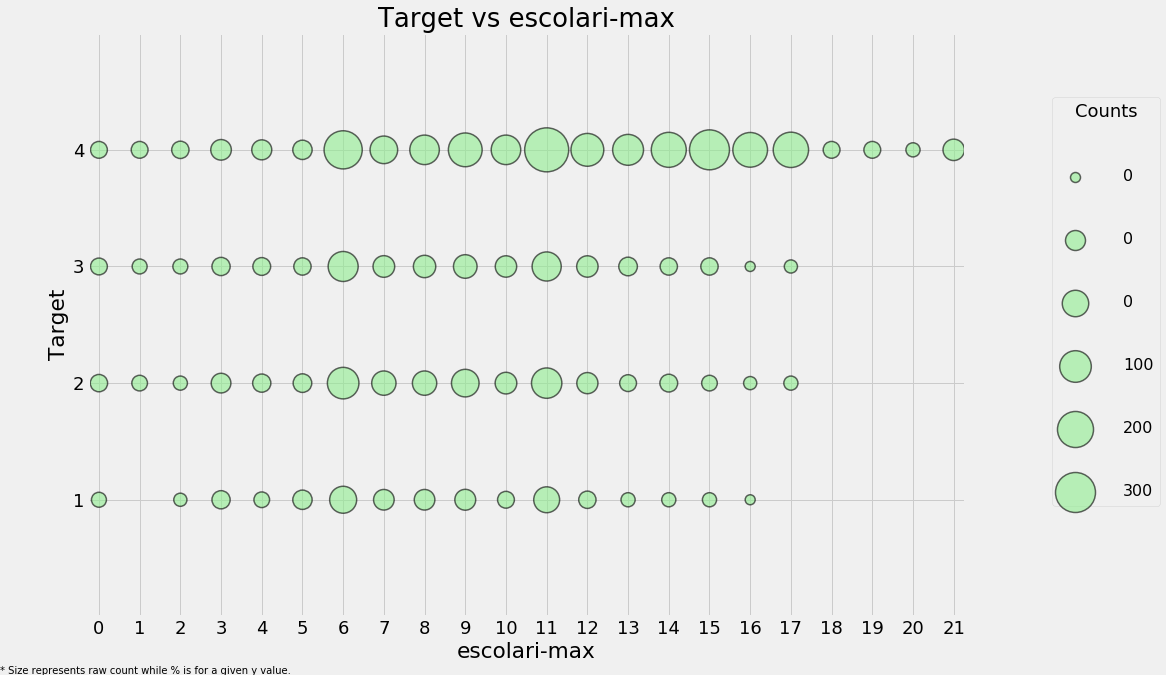

In [628]:
plot_categoricals('escolari-max', 'Target', final, annotate=False)

Text(0.5, 1.0, 'max schooling by target')

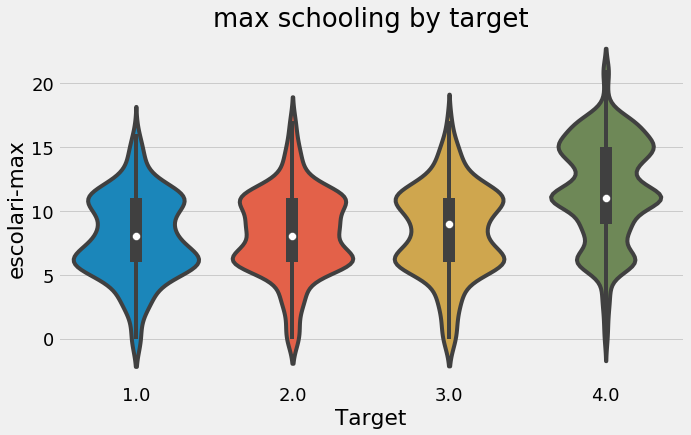

In [629]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Target', y='escolari-max', data=final)
plt.title('max schooling by target')

Text(0.5, 1.0, 'max schooling by target')

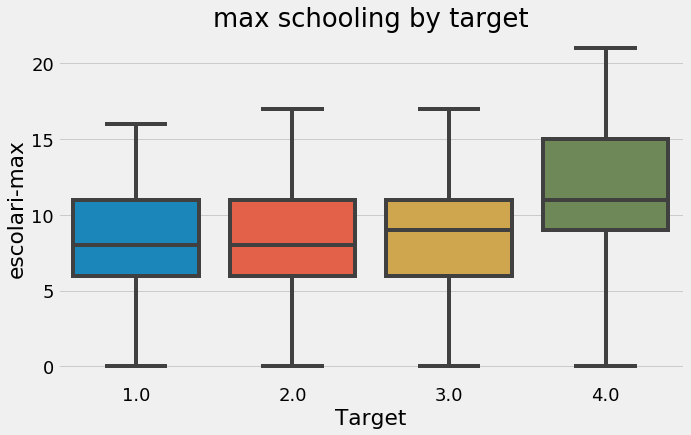

In [630]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Target', y='escolari-max', data=final)
plt.title('max schooling by target')

Text(0.5, 1.0, 'average schooling by target')

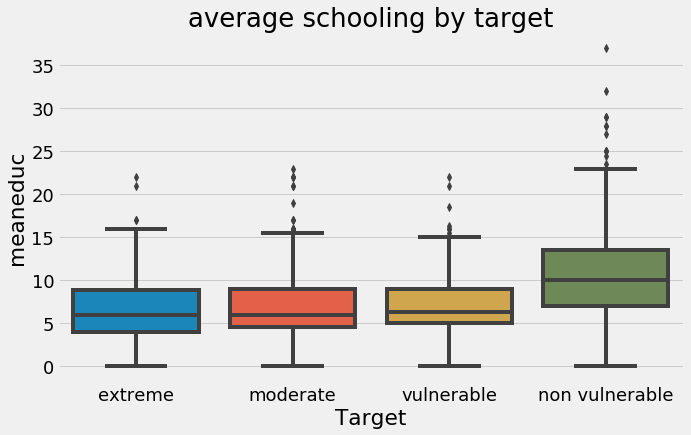

In [631]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'meaneduc', data = final)
plt.xticks([0, 1, 2, 3], poverty_mapping.values())
plt.title('average schooling by target')

Text(0.5, 1.0, 'overcrowding by target')

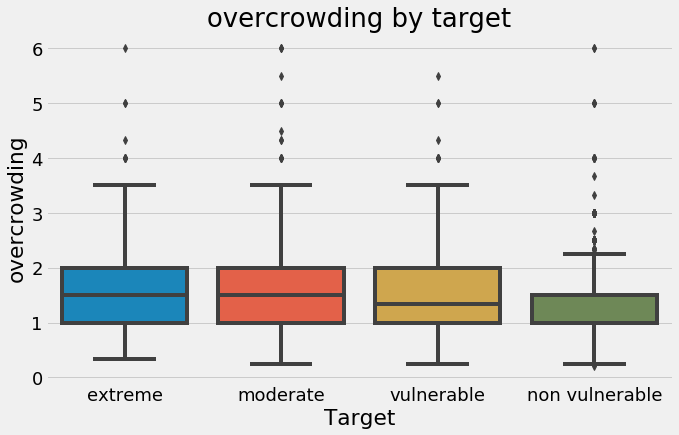

In [632]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'overcrowding', data = final)
plt.xticks([0, 1, 2, 3], poverty_mapping.values())
plt.title('overcrowding by target')

다른 중요할 것으로 예상되는 특징은 가장의 성별입니다. 우리가 데이터를 합친 이후로, 이제 개별 데이터에 대해서 돌아보고 가장의 성별에 대해서 알아봅시다.

In [633]:
head_gender = ind.loc[ind['parentesco1'] == 1, ['idhogar', 'female']]
final = final.merge(head_gender, on='idhogar', how='left').rename(
    columns={'female': 'female-head'})

In [634]:
final.groupby('female-head')['Target'].value_counts(normalize=True)

female-head  Target
0            4.0       0.682873
             2.0       0.136464
             3.0       0.123204
             1.0       0.057459
1            4.0       0.617369
             2.0       0.167670
             3.0       0.113500
             1.0       0.101462
Name: Target, dtype: float64

가장이 여성인 경우 아주 조금 빈곤 정도가 높은 것으로 보인다. (4만 보고 판단한 듯)

Text(0.5, 1.0, 'target by female head of household')

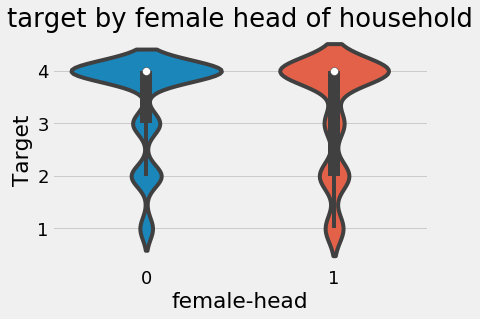

In [635]:
sns.violinplot(x='female-head', y='Target', data=final)
plt.title('target by female head of household')

우리는 또한 가장이 여성이냐 아니냐에 따라 평균 교육수준 차이도 볼 수 있다.

Text(0.5, 1.0, 'average education by target and female head of household')

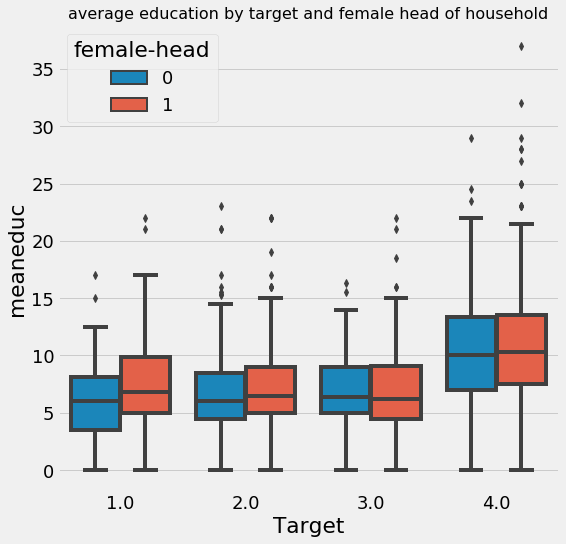

In [636]:
plt.figure(figsize=(8, 8))
sns.boxplot(x='Target', y='meaneduc', hue='female-head', data=final)
plt.title('average education by target and female head of household', size=16)

target의 값에 무관하게 가장이 여성인 경우 조금 더 높은 교육 수준을 가지고 있는 것처럼 보인다. 그러나 우리는 전반적으로 여성 가장이 있는 가구가 심각한 빈곤을 겪을 가능성이 높다고 보았다.

In [637]:
final.groupby('female-head')['meaneduc'].agg(['mean', 'count'])

,mean,count
female-head,,
0,8.968025,6384
1,9.237013,3903


전반적으로 가장이 남자인 경우보다 여자인 경우가 더 교육기간이 긴 것을 확인할 수 있다. 왜 이렇게 되었는지는 모르겠지만 이러한 통찰을 얻을 수 있었습니다.

## 4. Machine Learning Modeling
feature engineering/construction이 끝나고 난후에 우리는 머신러닝 모델을 만들 시간입니다. 우리의 모든 데이터는 각각의 가구별로 이미 나누어졌습니다. 이제 이를 바로 모델에 사용하면 될 것 같습니다. 모델링의 첫번째 단계로 RandonForestClassifier를 사용할 것입니다. 이는 점수판에 최상위에 오르게는 하지 않지만 적절한 초석을 다지기엔 좋습니다. 추후에 Gradient Boosting을 활용하여 더 강력한 모델을 만들겠습니다.

우리의 모델을 평가하기 위해서 10겹 교차검증을 사용하겠습니다. 이는 10번에 거쳐서 10겹에 나눠진 데이터 별로 훈련과 테스트를 진행합니다. 10겹 교차검증은 모델의 성능을 측정하는데 효과적인 방법입니다. 우리는 일반적인 방법을 거친것과 10겹 교차검증을 거친 것의 점수 또한 비교해 볼 것입니다.

우리는 평가지표로 F1 Macro 지표를 사용할 것이다.

### 4.1. RandomForest Baseline

In [638]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# 교차 검증을 위한 자체 평가지표
scorer = make_scorer(f1_score, greater_is_better=True, average='macro')

In [639]:
train_labels = np.array(list(final.loc[final['Target'].notnull(), 'Target'].astype(np.uint8)))
train_set = final[final['Target'].notnull()].drop(columns=['Id', 'idhogar', 'Target'])
test_set = final[final['Target'].isnull()].drop(columns=['Id', 'idhogar', 'Target'])

submission_base = test[['Id', 'idhogar']].copy()

In [640]:
train_set.head()

,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,v2a1-missing,v2a1,dependency,edjefe,edjefa,meaneduc,overcrowding,rooms,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,v18q1,tamviv,hhsize,hogar_nin,...,estadocivil3-std,estadocivil4-min,estadocivil4-max,estadocivil5-min,estadocivil5-max,estadocivil5-sum,estadocivil6-min,estadocivil6-max,estadocivil7-min,estadocivil7-max,estadocivil7-sum,estadocivil7-std,parentesco1-min,parentesco1-max,parentesco1-std,parentesco2-min,parentesco2-max,parentesco2-std,parentesco3-min,parentesco3-max,parentesco3-sum,parentesco4-min,parentesco4-max,parentesco4-sum,parentesco5-min,parentesco5-max,parentesco6-min,parentesco6-max,parentesco6-sum,parentesco7-min,parentesco7-max,parentesco8-min,parentesco8-max,parentesco9-min,parentesco9-max,parentesco9-sum,parentesco10-min,parentesco10-max,parentesco11-min,parentesco11-max,parentesco11-sum,parentesco12-min,parentesco12-max,parentesco12-sum,mobilephone-min,mobilephone-std,mobilephone-range_,rez_esc-min,rez_esc-max,escolari-min,escolari-max,escolari-sum,escolari-std,escolari-range_,age-min,age-max,age-sum,age-std,age-range_,inst-max,inst-std,inst-range_,escolari/age-min,escolari/age-max,escolari/age-sum,escolari/age-std,escolari/age-range_,inst/age-max,inst/age-std,inst/age-range_,tech-min,tech-sum,tech-std,tech-range_,female-head
0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,190000.0,0.0,10.0,0.0,10.0,1.000000,3,0,1,1,0,0,0,0,1,0.0,1,1,0,...,NaN,1,1,0,0,0,0,0,0,0,0,NaN,1,1,NaN,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,0,0.0,0.0,10,10,10,NaN,0,43,43,43,NaN,0,3,NaN,0,0.232558,0.232558,0.232558,NaN,0.000000,0.069767,NaN,0.000000,1,1,NaN,0,0
1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,135000.0,8.0,12.0,0.0,12.0,1.000000,4,0,1,1,0,0,0,0,1,1.0,1,1,0,...,NaN,1,1,0,0,0,0,0,0,0,0,NaN,1,1,NaN,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,0,0.0,0.0,12,12,12,NaN,0,67,67,67,NaN,0,7,NaN,0,0.179104,0.179104,0.179104,NaN,0.000000,0.104478,NaN,0.000000,2,2,NaN,0,0
2,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,False,0.0,8.0,0.0,11.0,11.0,0.500000,8,0,0,0,0,1,1,0,1,0.0,1,1,0,...,NaN,0,0,0,0,0,1,1,0,0,0,NaN,1,1,NaN,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0.0,0.0,11,11,11,NaN,0,92,92,92,NaN,0,4,NaN,0,0.119565,0.119565,0.119565,NaN,0.000000,0.043478,NaN,0.000000,0,0,NaN,0,1
3,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,180000.0,1.0,11.0,0.0,11.0,1.333333,5,0,2,2,1,1,2,1,3,1.0,4,4,2,...,0.0,0,0,0,0,0,0,0,0,1,1,0.5,0,1,0.5,0,1,0.5,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0,0.0,1.0,2,11,33,4.272002,9,8,38,100,14.899664,30,4,1.414214,3,0.250000,0.529412,1.366183,0.126943,0.279412,0.176471,0.033010,0.071207,2,8,0.0,0,0
4,1,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,130000.0,1.0,9.0,0.0,10.0,4.000000,2,0,1,1,2,1,3,2,2,0.0,4,4,2,...,0.0,0,0,0,0,0,0,0,0,1,1,0.5,0,1,0.5,0,1,0.5,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0,0.0,1.0,0,11,23,5.123475,11,7,30,76,11.690452,23,4,1.825742,4,0.000000,0.392857,0.965584,0.168946,0.392857,0.142857,0.060063,0.142857,1,4,0.0,0,0


우리는 다른 모델을 비교할 것이기 때문에 우리의 특징들을 scaling할 필요가 있어보입니다. 대부분의 앙상블 모델에는 불필요하지만, 거리와 관련된 척도인 K 최근접 이웃이나 서포트 벡터머신 과 같은 머신러닝 모델을 이용한다면 이런 스케일링은 필수적입니다. 다른 모델을 비교할 때 스케일링하는 것은 가장 안전한 방법중에 하나입니다. 그리고 우리는 각 특징의 중앙값을 손실치들에 넣어줄 것입니다.

파이프라인을 이용하면 손실치를 넣거나 스케일링을 하는데 간단하게 처리할 수 있습니다. 이는 학습 데이터를 학습 시키는 것과 학습 및 테스트 데이터를 변환하는 쓰일 것이다.

In [641]:
features = list(train_set.columns)

pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', MinMaxScaler())])

train_set = pipeline.fit_transform(train_set)
test_set = pipeline.transform(test_set)

데이터는 이제 결측치가 없고 0과 1사이의 값으로 스케일링 되었다. 이제 scikit-learn 모델에 직접적으로 쓰일 수 있는 데이터가 되었다!

In [642]:
model = RandomForestClassifier(n_estimators=100, random_state=10, n_jobs=-1)

# 10겹 교차 검증
cv_score = cross_val_score(
    model, train_set, train_labels, cv=10, scoring=scorer)

print(
    f'10겹 교차검증의 F1 Score = {round(cv_score.mean(), 4)} (표준편차 = {round(cv_score.std(), 4)})')

10겹 교차검증의 F1 Score = 0.3493 (표준편차 = 0.0493)


값이 그렇게 좋지 않지만 베이스라인 모델로 두고 개선할 여지를 남겨두자!

### 4.2. Feature Importances
트리 모델로 우리는 모델에서 특징의 필요없는 정도를 나타내는 상대적 랭킹을 볼 수 있습니다. 이는 변수를 분기하는데 사용되는 각각의 노드에 불 순수성에서 reduction의 합을 나타내며, 이들의 실제값에는 많은 관심을 두지 않습니다. 대신에 우리는 상대적인 점수에 초점을 맞출 것입니다.

만약 feature_importances 의 수치를 보고 싶다면, 모델을 전체 트레이닝 셋에 훈련시키고 해라.

In [643]:
model.fit(train_set, train_labels)

feature_importances = pd.DataFrame({'feature':features, 'importance':model.feature_importances_})
feature_importances.head()

,feature,importance
0,hacdor,0.000793
1,hacapo,0.000479
2,v14a,0.000403
3,refrig,0.001412
4,paredblolad,0.006185


아래는 feature importance를 plot하기 위한 짧은 함수이다. 나는 이 함수를 자주 쓰는데 이걸 복붙해서 잘 써라. 이 설명이 도움이 되길 바란다!

In [644]:
def plot_feature_importances(df, n=10, threshold=None):
    '''
    n개의 특성 중요도가 높은 피처들을 그린다. 만약 threshold가 명시되어 있다면 누적 중요도를 그리고 
    threshold 값에 닿을 때까지 필요한 피처들의 개수를 출력한다.
    트리 기반 특성 중요도를 가지고 사용하도록 설계되었다.

    PARAMETERS:
        - df (dataFrame) : 특성 중요도 데이터프레임. 컬럼은 "feature"와 "importance"여야 함.
        - n (int) : 그릴 가장 중요한 특성의 개수. 기본값은 15.
        - threshold (float) : 누적 중요도 그래프에서의 임계값. 기본 값은 None.

    RETURNS:
        - df (dataFrame) : 정규화된 특성 중요도를 기준으로 정렬된 데이터프레임과 누적 중요도 컬럼

    NOTE:
        - 여기서의 정규화는 합이 1임을 뜻한다.
        - 누적 중요도는 가장 중요한 피처부터 가장 중요하지 않은 피처까지 합산하여 계산된다.
        - 임계값 0.9는 누적 중요도의 90%를 도달하는 데 필요한 가장 중요한 피처를 나타낸다.
    '''

    plt.style.use('fivethirtyeight')

    # 특성 중요도를 기준으로 피처 정렬
    df = df.sort_values('importance', ascending=False).reset_index(drop=True)

    # 합이 1이 되도록 특성 중요도를 정규화
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    # 누적 중요도를 계산
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    plt.rcParams['font.size'] = 12

    # n개의 가장 중요한 피처 시각화 - barplot
    df.loc[:n, :].plot.barh(y='importance_normalized',
                            x='feature', color='darkgreen',
                            edgecolor='k', figsize=(12, 8),
                            legend=False, linewidth=2)
    plt.xlabel('normalized importance', size=18)
    plt.ylabel('')
    plt.title(f'{n} most important features', size=18)
    plt.gca().invert_yaxis()

    # threshold값이 있는 경우
    # 누적 중요도 그래프를 그림
    if threshold:
        # 누적 중요도 그래프
        plt.figure(figsize=(8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('number of features', size=16)
        plt.ylabel('cumulatvie importance', size=16)
        plt.title('cumulative feature importance', size=18)

        # 입계값을 넘기는 데 필요한 피처의 개수
        # 개수가 아니라 인덱스(실제 값을 없기 위해 1을 더할 필요가 있음)
        importance_index = np.min(
            np.where(df['cumulative_importance'] > threshold))

        # 수직선을 추가
        plt.vlines(importance_index+1, ymin=0, ymax=1.05,
                   linestyles='--', color='red')
        plt.show()

        print('누적 중요도의 {:.0f}%를 넘기기 위해 {}개의 피처가 필요하다'.format(
            100*threshold, importance_index+1))
        
    return df

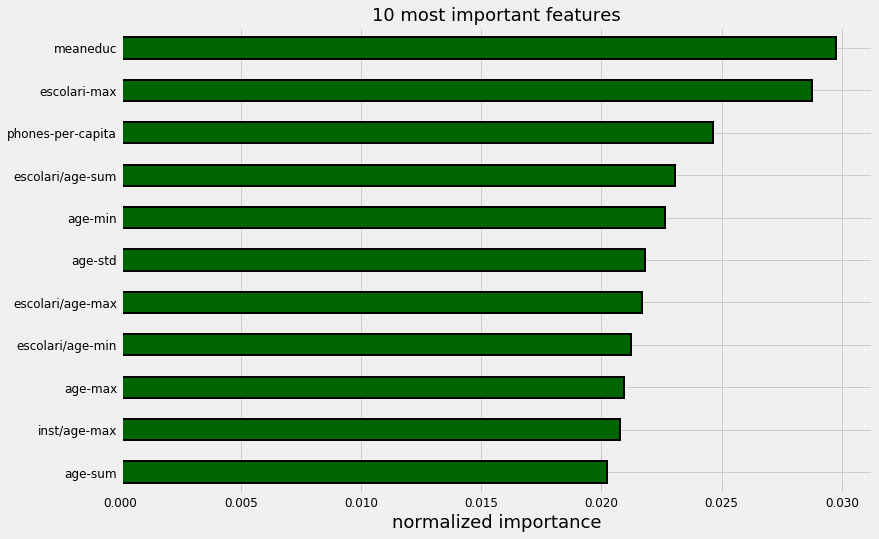

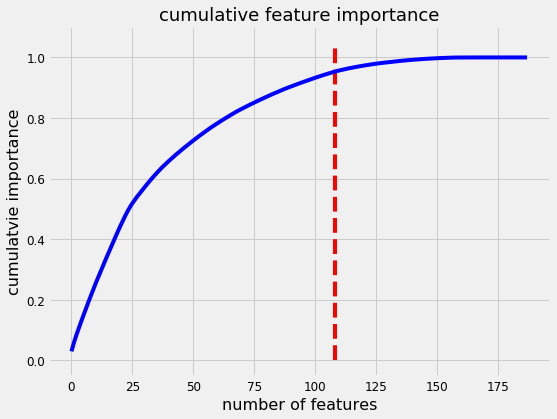

누적 중요도의 95%를 넘기기 위해 108개의 피처가 필요하다


In [645]:
norm_fi = plot_feature_importances(feature_importances, threshold=0.95)

교육은 정말 중요해보여요! 가장 중요한 변수는 각 가정에서 교육의 평균양이었습니다. 그리고 나는 이러한 변수들이 상당히 연관관계가 클 것 같습니다. 그래서 우리는 그들을 지워주려고 합니다. 다른 중요한 특징은 우리가 만들었넌 변수들의 조합이고 그것들은 이미 데이터 안에 존재합니다.

106에서 180개 정도의 피쳐만 있어도 90%의 importance를 달성한 것을 알 수 있습니다. 이는 우리가 몇몇 feature들을 지워줘야 한다는 이야기 입니다. 그러나 feature_importances는 특징의 어느 방향이 중요한지 말해주지 않습니다. 그들은 단지 어느 특징이 모델과 관련이 있었는지만 알려줍니다. (예를 들어, feature importance는 교육수준이 덜 한 것과 더한 것 중 어느 것이 더 심각한 빈곤을 가져오는지 알려주지 않습니다.)

In [646]:
# 피처의 분포를 Target값에 따라 보여줌
def kde_target(df, variable):
    df = df[df['Target'].notnull()]
    colors = {1:'red', 2:'orange', 3:'blue', 4:'green'}
    
    plt.figure(figsize=(12, 8))
    for level in df['Target'].unique():
        subset = df[df['Target'] == level].copy()
        sns.kdeplot(subset[variable].dropna(),
                   label=f'Poverty Level: {level}',
                   color=colors[int(subset['Target'].unique())])
    plt.xlabel(variable)
    plt.ylabel('density')
    plt.title('{} distribution'.format(variable.capitalize()))

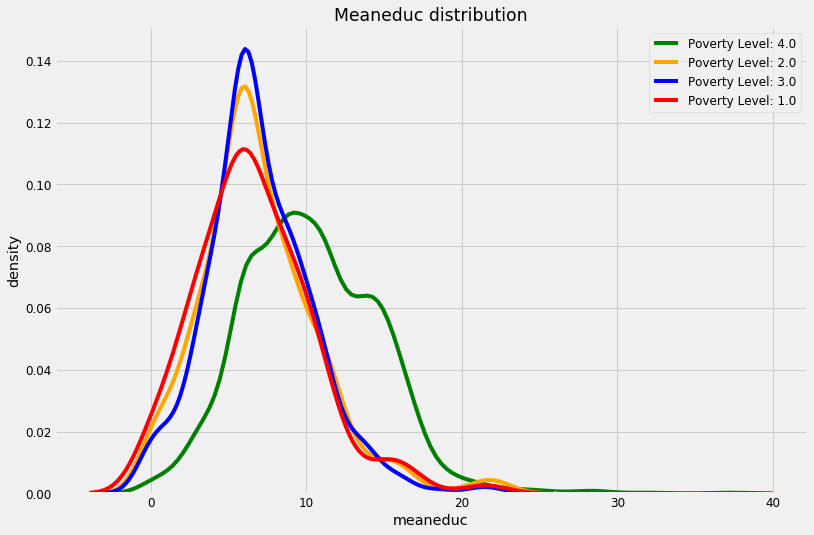

In [647]:
kde_target(final, 'meaneduc')

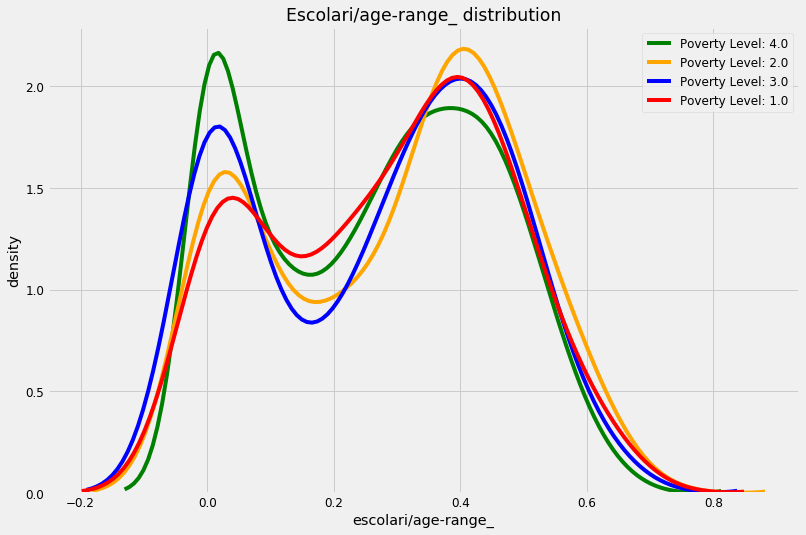

In [648]:
kde_target(final, 'escolari/age-range_')

## 5. Model Selection
이제 우리는 좋은 변수들의 집합을 가지고 있습니다. 이제 모델링을 해볼 차례입니다. 우리는 이미 RandomForestClassifier로 0.35점의 성과를 냈습니다. 그러나 머신러닝에서 어느 모델이 주어진 데이터셋에서 최고로 작동을 자랄지 아는 방법이 없습니다. 다음의 그림은 가우시안 나이브 베이즈가 그라디언트 부스팅보다 좋은 성적을 낸적이 있는 문제도 있다는 것입니다.

![algorithm-comparison](../img/algorithm_comparison.png)

이 플롯이 말하고자 하는 바는 어느 것이 최적인지를 찾기위해서는 여러가지 다른 모델들을 테스트 해봐야 한다는 것입니다. 많은 사람들이 끝내 그라디언트 부스팅에 머물지만, 우리는 다른 선택지들을 좀 살펴볼 필요가 있다. 여기에 굉장히 많은 선택지들이 있다. 다는 해보지 못하겠지만 일부라도 실험해보도록 하자.

우리는 각 모델을 을 평가할 수 있는 함수를 짜야한다. 운좋게도 우리의 모델은 작기 때문에 상대적으로 빠르게 될 것이다. 결과를 담을 데이터프레임을 만들고 각모델에 대해서 결과를 데이터프레임에 행에 추가해 줄 것이다.

In [649]:
# 사용할 모델 import
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [650]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# 경고 필터링
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# 결과를 저장할 데이터프레임
model_results = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std'])

In [651]:
# 지정된 모델로 10겹 교차검증을 실시
def cv_model(train, train_labels, model, name, model_results=None):
    cv_scores = cross_val_score(
        model, train, train_labels, cv=10, scoring=scorer, n_jobs=-1)
    print(
        f'10겹 교차검증 CV 점수: {round(cv_scores.mean(), 5)} (표준편차 {round(cv_scores.std(), 5)})')
    
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model': name, 
                                                           'cv_mean': cv_scores.mean(), 
                                                           'cv_std': cv_scores.std()},
                                                           index = [0]),
                                             ignore_index = True)
    return model_results

In [652]:
model_results = cv_model(train_set, train_labels,
                         LinearSVC(), 'LSVC', model_results)

10겹 교차검증 CV 점수: 0.27741 (표준편차 0.04277)


더 점수가 낮아졌다. 그러나 아직 하이퍼 파라미터 튜닝을 하지 않았기 때문에 실제 성능이 더 개선될 수 있다.

In [653]:
model_results = cv_model(train_set, train_labels,
                         GaussianNB(), 'GNB', model_results)

10겹 교차검증 CV 점수: 0.18958 (표준편차 0.04294)


가우시안 나이브 베이즈 모델의 성능은 굉장히 형편없었다.

In [654]:
model_results = cv_model(train_set, train_labels, MLPClassifier(
    hidden_layer_sizes=(32, 64, 128, 64, 32)), 'MLP', model_results)

10겹 교차검증 CV 점수: 0.31535 (표준편차 0.04845)


다층 퍼셉트론은 굉장한 성능을 보여주었습니다. 우리가 튜닝을 좀한다면 더 좋아질 것 같습니다. 그러나 신경망에서 작은 양의 데이터는 문제가 될 수 있습니다.

In [655]:
model_results = cv_model(train_set, train_labels,
                         LinearDiscriminantAnalysis(),
                         'LDA', model_results)

10겹 교차검증 CV 점수: 0.31184 (표준편차 0.05927)


해당 모델을 경고창을 없애지 않고 한다면 위와 같은 경고메시지를 만날 수 있는데 이는, 유사한 성격을 가진 컬럼이 많아서 다중 공선성의 문제가 생길 수 있기 때문입니다. 하지만 우리가 제일 처음에 가이드 라인으로 사용했던 랜덤포레스트와 비슷한 점수를 내기 때문에 공선성 문제를 해결하고 이 모델을 다시 시험해 볼 것입니다.

In [656]:
model_results = cv_model(train_set, train_labels,
                         RidgeClassifierCV(), 'RIDGE', model_results)

10겹 교차검증 CV 점수: 0.27858 (표준편차 0.03135)


선형모델은 생각보다 잘 되었습니다. 이는 단순한 모델이 이 문제에서 큰 전진을 보일 수 있다는 것을 나타낼 수 있다. (그러나 우리는 아마도 더 강력한 방법을 사용할 것이다.)

In [657]:
for n in [5, 10, 20]:
    print(f'\nKNN with {n} neighbors\n')
    model_results = cv_model(train_set, train_labels,
                            KNeighborsClassifier(n_neighbors=n),
                            f'knn={n}', model_results)


KNN with 5 neighbors

10겹 교차검증 CV 점수: 0.31844 (표준편차 0.02311)

KNN with 10 neighbors

10겹 교차검증 CV 점수: 0.29539 (표준편차 0.03998)

KNN with 20 neighbors

10겹 교차검증 CV 점수: 0.27013 (표준편차 0.02263)


마지막으로는 결정트리에 앙상블을 이용한 랜덤포레스트의 변형인 ExtraTreeClassifier를 이용해보겠습니다.

In [658]:
from sklearn.ensemble import ExtraTreesClassifier

model_results = cv_model(train_set, train_labels, 
                         ExtraTreesClassifier(n_estimators=100, random_state=10),
                         'EXT', model_results)

10겹 교차검증 CV 점수: 0.32199 (표준편차 0.04616)


### 5.1. Comparing Model Performance
모델링 결과 데이터프레임을 가지고 어느 모델의 성능이 가장 좋은지 시각화할 수 있다.

In [659]:
model_results = cv_model(train_set, train_labels,
                        RandomForestClassifier(n_estimators=100, random_state=10),
                        'RF', model_results)

10겹 교차검증 CV 점수: 0.34933 (표준편차 0.04931)


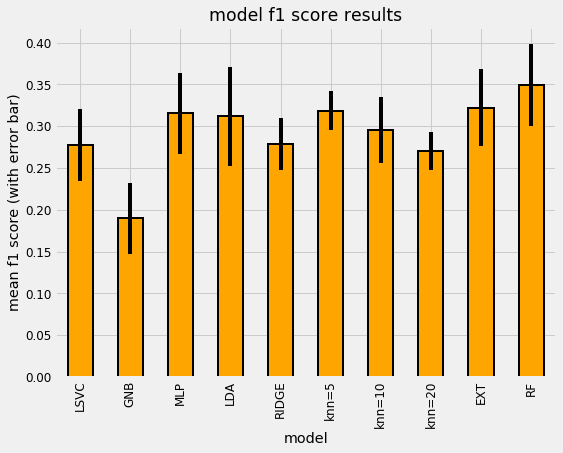

In [660]:
model_results.set_index('model', inplace=True)
model_results['cv_mean'].plot.bar(color='orange', figsize=(8, 6),
                                 yerr=list(model_results['cv_std']),
                                 edgecolor='k', linewidth=2)
plt.title('model f1 score results')
plt.ylabel('mean f1 score (with error bar)')
model_results.reset_index(inplace=True)

많은 사람들은 랜덤포레스트가 최고의 방법이라고 볼 수 있다. 그러나 우리는 아무런 파라미터 튜닝을 하지 않았기 때문에 이 모델들은 완벽하지 않다, 이 결과는 왜 많은 캐글의 이용자들이 트리기반의 앙상블 메소드를 쓰는지 보여준다. 하이퍼 파라미터 튜닝은 머신러닝 모델의 성능을 향상시켜주지만, 모든 모델의 파라미터 튜닝을 하고 있기엔 시간이 없다. 아래의 그래프는 사이킷런의 기본 값으로 학습시켰을 때와 하이퍼파라미터 튜닝을 했을 때를 비교한 것이다.

![hyperparameter_improvement](../img/hyperparameter_improvement.png)

대부분의 경우에 정확도를 많아도 10퍼센트까지만 올릴 수 있다. 지금은 랜덤포레스트가 최고라고 말할 수 있지만, 나중에 우리가 사용하게될 그라디언트 부스팅 모델에 대해서 알아볼 것이다. 우리는 더 강력한 LightGBM모델을 사용할 것이다.

## 6. Make Submission
제출을 위해, 우리는 테스트 데이터가 필요하다. 운좋게도 우리는 테스트 데이터를 훈련데이터를 전처리한 것과 동일하게 처리해 두었다. 테스트 셋의 결과 제출은 아래와 같다. 비록 우리가 모든 가구들에 대해 결과를 예측했더라도 우리는 개인 row당 하나의 타겟 값을 원한다. 그러나 가장의 것만 점수에 합산 될 것이다.

```
Id,Target
ID_2f6873615,1
ID_1c78846d2,2
ID_e5442cf6a,3
ID_a8db26a79,4
ID_a62966799,4
```

submissin_base는 모든 개개인에 대한 정보를 다 가지고 있다. 그런데 우리가 가진 test_id는 가구별로 예측이 되어있다. 예측시에, 우리는 가구 단위로 예측을 했고, 우리는 두 개의 데이터프레임을 left outer join을 통해 모든 가구원들에게 가구별 타겟 값을 할당할 것이다.  이것은 모든 구성원들에게 값이 돌아가지만, 가장이 없는 가구의 경우에는 예측이 되지 않기 때문에 4로 배정한다.

In [661]:
test_ids = list(final.loc[final['Target'].isnull(), 'idhogar'])

다음의 함수는 모델, 학습 데이터셋, 라벨 그리고 테스트 데이터셋을 사용하여 다음과 같은 작업을 수행한다:

* `fit`을 사용하여 학습 데이터로 모델 학습
* `predict`를 사용하여 테스트 데이터로 예측
* 저장하고 대회에 올릴 제출 데이터프레임 생성

In [662]:
def submit(model, train, train_labels, test, test_ids):
    # 모델 학습
    model.fit(train, train_labels)
    # 모델 예측
    predictions = model.predict(test)
    predictions = pd.DataFrame({'idhogar':test_ids, 'Target':predictions})
    
    # 제출 데이터프레임 생성
    submission = submission_base.merge(predictions,
                                      on='idhogar',
                                      how='left').drop(columns=['idhogar'])
    
    # 가장이 없는 가구의 target값 채우기
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)
    
    return submission

랜덤 포레스트로 제출해보자.

In [663]:
rf_submission = submit(RandomForestClassifier(n_estimators=100, random_state=10, n_jobs=-1),
                      train_set, train_labels,
                      test_set, test_ids)
rf_submission.to_csv('../data/rf_submission_1.csv', index=False)

대회에 제출하면 0.370의 점수를 얻을 수 있다.

## 7. Feature Selection
모델의 성능을 평가하기 위한 하나의 방법은 feature_selection이다. 이는 우리의 모델에서 유의미한 컬럼들만 남기기 위해서 진행하는 것이다. 가장 유용하다는 것은 많은 다른 것들을 의미하고, 이런 가장 중요한 컬럼들 찾는데 많은 경험적 지식들이 있다. 이 커널에서는 우리는 0.95이상의 상관계수 이상을 가지는 임의의 컬럼들을 지우고, Recursive feature elimination 기법을 이용할 것이다.

일단은 0.95를 임계점으로 하여 컬럼들을 찾아내자.

In [665]:
train_set = pd.DataFrame(train_set, columns=features)

# 상관계수 행렬 생성
corr_matrix = train_set.corr()

# 상삼각행렬 추출
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,v2a1-missing,v2a1,dependency,edjefe,edjefa,meaneduc,overcrowding,rooms,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,v18q1,tamviv,hhsize,hogar_nin,...,estadocivil3-std,estadocivil4-min,estadocivil4-max,estadocivil5-min,estadocivil5-max,estadocivil5-sum,estadocivil6-min,estadocivil6-max,estadocivil7-min,estadocivil7-max,estadocivil7-sum,estadocivil7-std,parentesco1-min,parentesco1-max,parentesco1-std,parentesco2-min,parentesco2-max,parentesco2-std,parentesco3-min,parentesco3-max,parentesco3-sum,parentesco4-min,parentesco4-max,parentesco4-sum,parentesco5-min,parentesco5-max,parentesco6-min,parentesco6-max,parentesco6-sum,parentesco7-min,parentesco7-max,parentesco8-min,parentesco8-max,parentesco9-min,parentesco9-max,parentesco9-sum,parentesco10-min,parentesco10-max,parentesco11-min,parentesco11-max,parentesco11-sum,parentesco12-min,parentesco12-max,parentesco12-sum,mobilephone-min,mobilephone-std,mobilephone-range_,rez_esc-min,rez_esc-max,escolari-min,escolari-max,escolari-sum,escolari-std,escolari-range_,age-min,age-max,age-sum,age-std,age-range_,inst-max,inst-std,inst-range_,escolari/age-min,escolari/age-max,escolari/age-sum,escolari/age-std,escolari/age-range_,inst/age-max,inst/age-std,inst/age-range_,tech-min,tech-sum,tech-std,tech-range_,female-head
hacdor,NaN,0.624324,-0.143713,-0.055073,-0.105112,0.053262,-0.021422,0.060396,0.139910,0.072131,0.101985,-0.006039,-0.005401,-0.130923,-0.003818,0.068883,0.191171,0.045614,-0.037777,-0.021824,-0.008108,-0.007148,-0.134352,-0.051855,0.058215,-0.008967,0.088413,-0.006580,-0.002880,-0.016964,-0.007148,-0.010478,-0.050384,0.042438,0.023042,-0.027280,0.001265,0.032345,-0.005401,NaN,-0.005401,-0.064282,-0.047444,0.052335,0.151861,0.021870,-0.048189,-0.040258,-0.029605,0.010581,0.026791,-0.010283,0.025574,0.001103,0.025404,0.082523,-0.022945,0.012861,-0.050166,-0.017828,-0.067614,0.583197,-0.181283,0.186709,0.057368,0.147793,0.220037,0.105136,0.200622,0.268084,0.110120,-0.056616,0.283206,0.234749,0.256228,...,-0.032110,-0.025089,-0.049018,-0.025698,0.029706,0.041293,-0.025089,-0.020167,-0.036167,0.046793,0.105287,0.004562,-0.057005,NaN,-0.184963,NaN,0.022845,-0.046191,NaN,0.081380,0.144878,NaN,0.039366,0.099535,NaN,0.056985,NaN,0.093234,0.190636,NaN,0.014897,NaN,-0.012992,NaN,0.010120,0.012507,NaN,0.011264,NaN,0.080892,0.075948,NaN,0.072942,0.081928,-0.016343,NaN,NaN,NaN,0.110453,-0.126581,-0.066090,0.017404,-0.000265,0.062720,-0.128221,-0.073010,0.039064,0.001953,0.090741,-0.070877,-0.030679,0.027641,-0.113229,0.040286,0.084740,0.034707,0.108874,0.012362,0.008216,0.069828,-0.059901,0.100484,NaN,NaN,0.016057
hacapo,NaN,NaN,-0.154749,-0.062110,-0.092562,0.036795,-0.020661,0.062616,0.124520,0.066715,0.111904,-0.004544,-0.004064,-0.124567,-0.002873,-0.003519,0.206423,0.032552,-0.048015,-0.016422,-0.006101,-0.005379,-0.125825,-0.048910,0.054289,-0.006747,0.122333,-0.022836,-0.008292,0.041293,-0.005379,-0.007884,-0.044062,0.018669,0.063279,-0.046656,0.016337,0.045107,-0.004064,NaN,-0.004064,-0.034762,-0.035699,0.027959,0.110707,0.010169,-0.036260,-0.038271,-0.032999,0.018682,0.007766,0.000237,0.007112,0.025496,0.015219,0.054801,-0.021961,0.002864,-0.042787,-0.028024,-0.076263,0.445405,-0.172382,0.174432,0.088729,0.168476,0.183967,0.064559,0.149317,0.236029,0.105777,-0.045953,0.263010,0.213700,0.204935,...,-0.041841,-0.018878,-0.036884,-0.019336,0.029260,0.050758,-0.018878,-0.018033,-0.011383,0.025134,0.098664,-0.015792,-0.042893,NaN,-0.153309,

In [668]:
to_drop = [column for column in upper.columns if any(abs(upper[column]) >0.95)]
to_drop

['v18q-count', 'female-sum']

In [669]:
train_set = train_set.drop(columns=to_drop)
train_set.shape

(2973, 186)

In [670]:
test_set = pd.DataFrame(test_set, columns=features)
train_set, test_set = train_set.align(test_set, axis=1, join='inner')
features = list(train_set.columns)

features

['hacdor',
 'hacapo',
 'v14a',
 'refrig',
 'paredblolad',
 'paredzocalo',
 'paredpreb',
 'pisocemento',
 'pareddes',
 'paredmad',
 'paredzinc',
 'paredfibras',
 'paredother',
 'pisomoscer',
 'pisoother',
 'pisonatur',
 'pisonotiene',
 'pisomadera',
 'techozinc',
 'techoentrepiso',
 'techocane',
 'techootro',
 'cielorazo',
 'abastaguadentro',
 'abastaguafuera',
 'abastaguano',
 'sanitario1',
 'sanitario2',
 'sanitario3',
 'sanitario5',
 'sanitario6',
 'energcocinar1',
 'energcocinar2',
 'energcocinar3',
 'energcocinar4',
 'elimbasu1',
 'elimbasu2',
 'elimbasu3',
 'elimbasu4',
 'elimbasu5',
 'elimbasu6',
 'tipovivi1',
 'tipovivi2',
 'tipovivi3',
 'tipovivi4',
 'tipovivi5',
 'computer',
 'television',
 'lugar1',
 'lugar2',
 'lugar3',
 'lugar4',
 'lugar5',
 'lugar6',
 'area1',
 'v2a1-missing',
 'v2a1',
 'dependency',
 'edjefe',
 'edjefa',
 'meaneduc',
 'overcrowding',
 'rooms',
 'r4h1',
 'r4h2',
 'r4h3',
 'r4m1',
 'r4m2',
 'r4m3',
 'r4t1',
 'r4t2',
 'v18q1',
 'tamviv',
 'hhsize',
 'hogar_n

### 7.1. Recursive Feature Elimination with Random Forest

RFECV는 교차검증을 이용한 반복적 특징 제거법입니다. 선택자는 반복적인 방법을 통해서 모델의 feature_importance를 진행합니다. 각각의 반복에서, RFECV는 특징은 부분이나 특징의 개수를 점점 줄여갑니다. 이 반복은 더이상 교차검증 점수가 향상되지 않을 때 까지 진행합니다.

선택자 객체를 생성하기 위해, 우리는 모델을 넘기고, 각각의 반복시행마다 없앨 컬럼들의 개수, 교차검증의 겹수, 우리의 custom scorer 그리고 선택자가 참고할 수 있는 다른 파라미터들을 넘겨줍니다.

In [671]:
from sklearn.feature_selection import RFECV

# 특성 선택을 위한 모델 생성
estimator = RandomForestClassifier(random_state=10, n_estimators=100, n_jobs=-1)

# 인스턴스 생성
selector = RFECV(estimator, step=1, cv=3, scoring=scorer, n_jobs=-1)

다음으로는 선택자를 훈련세트를 이용하여 학습시킵니다. 이는 교차검증점수가 더 이상 낮아질 때가 없을 때 까지 계속해서 진행 할 것입니다.

In [672]:
selector.fit(train_set, train_labels)

RFECV(cv=3,
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=-1,
                                       oob_score=False, random_state=10,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=-1,
      scoring=make_scorer(f1_score, average=macro), step=1, verbose=0)

우리는 각각의 반복마다 훈련 점수를 볼 수 있습니다. 다음의 코드는 교차검증 점수와 컬럼의 개수를 그림화 한 것입니다.

74

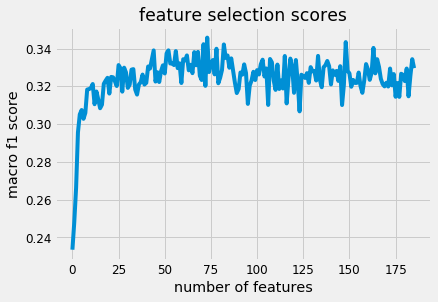

In [674]:
plt.plot(selector.grid_scores_)

plt.xlabel('number of features')
plt.ylabel('macro f1 score')
plt.title('feature selection scores')
selector.n_features_

우리는 96개의 feature를 넣을 때가지만 해도 점수의 향상을 알 수 있었습니다. selector에 따르면 최적의 피쳐의 수는 정해졌습니다.

각각의 컬럼들의 랭킹은 훈련된 선택자 객체를 통해 알 수 있습니다. 이들은 반복을 거듭함에 따라 평균된 중요도를 나타냅니다. 특징들은 같은 랭킹을 공유할수 있습니다. rank가 1인 컬럼들만 사용될 것입니다.

In [676]:
rankings = pd.DataFrame({'feature': list(train_set.columns), 'rank': list(
    selector.ranking_)}).sort_values(by='rank')
rankings.head(10)

,feature,rank
101,female-std,1
54,area1,1
83,roof,1
84,floor,1
85,wall+roof+floor,1
105,estadocivil1-sum,1
86,warning,1
48,lugar1,1
87,bonus,1
121,estadocivil7-sum,1


마지막으로 우리들의 교차검증 결과를 확인해 봅시다.

In [677]:
train_selected = selector.transform(train_set)
test_selected = selector.transform(test_set)

In [678]:
train_selected

array([[1.        , 0.        , 0.        , ..., 0.        , 0.5       ,
        0.04545455],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.09090909],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 1.        , ..., 0.57777778, 0.5       ,
        0.22727273],
       [1.        , 0.        , 0.        , ..., 0.0852459 , 0.5       ,
        0.09090909],
       [1.        , 0.        , 1.        , ..., 0.4       , 0.5       ,
        0.22727273]])

In [680]:
# 데이터프레임으로 변환
selected_features = train_set.columns[np.where(selector.ranking_==1)]
train_selected = pd.DataFrame(train_selected, columns=selected_features)
test_selected = pd.DataFrame(test_selected, columns=selected_features)

In [681]:
model_results = cv_model(train_selected, train_labels, model, 'RF-SEL', model_results)

10겹 교차검증 CV 점수: 0.35686 (표준편차 0.04439)


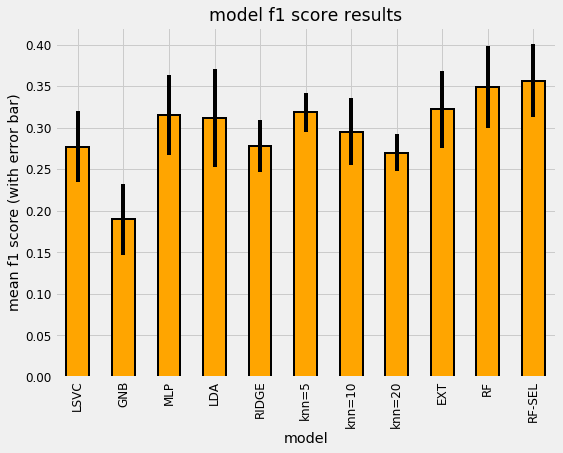

In [682]:
model_results.set_index('model', inplace=True)
model_results['cv_mean'].plot.bar(color='orange', figsize=(8, 6),
                                 yerr=list(model_results['cv_std']),
                                 edgecolor='k', linewidth=2)
plt.title('model f1 score results')
plt.ylabel('mean f1 score (with error bar)')
model_results.reset_index(inplace=True)

선택된 피처들을 사용한 모델이 교차검증에서 조금 더 성능이 좋은 것을 볼 수 있다. 우리는 다음 모델인 Gradient Boosting 머신에서 사용하기 위해 피처들 모두 유지할 것이다. (그대로 둔다는 의미.. 비교하려나)

## 8. Upgrading Our Model: Gradient Boosting Model
우리가 랜덤포레스트를 통해 좋은 점수를 받은 이후에, 그라디언트 부스팅모델을 이용할 차례입니다. 만약 독자가 캐글에 익숙한 사용자라면 GBM모델이 많은 데이터가 정형화되어있고 데이터셋이 크지 않은 컴피티션에서 승리한 것을 보았을 것입니다.

많은 자세한 것들을 언급하진 않겠지만 실행에 초점을 맞춰봅시다. 우리는 LightGBM을 사용할 것이지만 다른 여러 선택지가 사이킷런,XGBOOST,CatBoost가 있습니다. 첫번 째 하이퍼 파라미터의 세트는 우리가 위에서 찾아왔던 것들을 기반으로 세팅하겠습니다.

### 8.1. Choosing Number of Estimators with Early Stopping
반복시행의 수를 선택하기 위해 우리는 early stopping으로 5겹 교차검증을 이용할 것입니다. 이것은 우리가 이용하는 척도 Macro F1 수치가 100번의 훈련 반복시행에 있어서 증가하지 않을 때 까지 반복시행을 추가합니다. 이 수치를 이용하기 위해 custom metric을 이용합시다.

In [683]:
def macro_f1_score(labels, predictions):
    # 행으로만 이루어진 결과치를 4열씩 차례대로 배치하고 그 4열에서 max를 각각 추출
    # 원-핫 인코딩처럼 한다는 이야기 그리고 최종 결과값은 최고 인덱스 값을 뽑을 예정 
    predictions = predictions.reshape(len(np.unique(labels)), -1).argmax(axis=0)
    
    metric_value = f1_score(labels, predictions, average='macro')
    
    return 'macro_f1', metric_value, True

## 9. Light Gradient Boosting Machine Implementation
아래의 함수는 K겹 교차검증을 이용한 그라디언트 부스팅 모델을 학습시키는 함수이며, early stopping은 훈련데이터가 과적합되는 것을 막는 파라미터입니다. 이 함수는 교차검증을 통해 훈련시키고 각 계층마다의 예측에 대한 확률을 기록합니다. 이것이 어떻게 작동하는지를 알기 위해서 각 폴드별 예측치를 반환하는 prediction을 반환하고 컴피티션의 업로드를 위해서 submission 또한 업로드 할 것 입니다.

그라디언트 부스팅에서 하이퍼파라미터를 고르는 것은 어려운일입니다. 그리고 이는 모델 최적화를 통해 이루어질 것입니다. 여기서는 일련의 하이퍼 파라미터들을 세팅할 것입니다.

우리는 n_estimators를 10000으로 세팅하였지만, 우리는 교차검증 점수가 더 이상 오르지 않는 순간을 캐치하고 이를 중단 시키는 early_stopping을 설정하기 때문에 만 번의 반복 시행까지는 가지 않을 것입니다. 많은 것들이 이 함수에서 이루어집니다. 이를 모두 읽고 여러분의 것으로 만드세요. 코드에 주석들을 달아 놨습니다.